In [1]:
import sys
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from statistics import mean
# Importing the main code.
module_path = os.path.abspath(os.path.join('../src/ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ocloc import ProcessingParameters, ClockDrift, suppress_stdout

In [2]:
# Parameters for locating the files where the correlation files and station 
# information is contained.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"
# path2data_dir = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/correlations_O20"
station_file = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info"
reference_time = '2014-08-21T00:00:00.000000Z'

In [3]:
def bootstrap_cd(cd):
    """
    Method to bootstrap the t_app values and return a new
    ClockDrift object with the bootstrapped values called
    bootstrapped_cd
    """
    bootstrapped_cd = cd.copy()
    correlations_with_tapp = []
    for c in bootstrapped_cd.correlations:
        if not np.isnan(c.t_app[-1]):
            correlations_with_tapp.append(c)
    index_list = np.random.choice(range(len(correlations_with_tapp)),
                                  replace=True,
                                  size=len(correlations_with_tapp))

    res_list = [correlations_with_tapp[i] for i in index_list]
    bootstrapped_cd.correlations = res_list
    return bootstrapped_cd

def get_a_and_b_values(cd):
    """
    Function to get a and b values when the station was included in the inversion.
    """
    a_vals = []
    b_vals = []
    stations = []
    for sta in cd.stations:
        if not sta.needs_correction:
            continue
        if sta.a[-1] == 0 and sta.b[-1] == 0:
            include = False
            for c in cd.get_correlations_of_station(sta.code):
                if not np.isnan(c.t_app[-1]):
                    include = True
                    break
            if not include:
                continue
        a_vals.append(sta.a[-1])
        b_vals.append(sta.b[-1])
        stations.append(sta.code)
    return a_vals, b_vals, stations

First we set some minimum requirements for an inversion to be considered in the bootstrap. This step is necesary in case a station doesn't meet the minimum number of crosscorrelations, has no station connections, or does not have enough correlation periods.

In [4]:
min_number_of_total_correlations=3
min_number_correlation_periods=2
min_number_of_stationconnections=2
days_apart=30
results = {}

We load a clock drift object with specific snr and dist trh that was precomputed in step 6: refined inversion.

In [5]:
file_name = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/bootstrap/clockdrift.obj"
path_2_clockdrift = os.path.join(file_name)
with open(path_2_clockdrift, 'rb') as f:
    cd = pickle.load(f)

In [6]:
snr_trh = 30
dist_trh = 2.5

First we check that the corrections we applied make the waveforms align for each time-lapse.

output_dir = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/bootstrap/"
f = open(output_dir + "refinedInversion_bootstrap.pkl", "wb")
pickle.dump(results, f)
f.close()

In [7]:
output_dir = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/bootstrap/"
with open(output_dir + "refinedInversion_bootstrap.pkl", 'rb') as f:
    results = pickle.load(f)

In [8]:
iteration = "snr_trh_" + str(snr_trh) + "__dist_trh_" + str(dist_trh)
for station in cd.stations:
    if not station.needs_correction:
        continue
    sta = station.code
    for i, inverse_method in enumerate([
        "weighted a ",
        "weighted b "
    ]):

        title = inverse_method + sta + iteration
        values = results[title]
        x = np.sort(values)
        n = x.size
        y = np.arange(1, n+1) / n
        
        for conf_interval in [0.05, 0.95]:
            x_interval = x[np.argmin(np.abs(np.array(y)-conf_interval))]
            if inverse_method == "weighted a ":
                if conf_interval == 0.05:
                    station._05CI_a = x_interval
                elif conf_interval == 0.95:
                    station._95CI_a = x_interval
            if inverse_method == "weighted b ":
                if conf_interval == 0.05:
                    station._05CI_b = x_interval
                elif conf_interval == 0.95:
                    station._95CI_b = x_interval
            
        print(station.code, " confidence interval\n",
              "a [5, 95]:",
              station._05CI_a, station._95CI_a, "\n"
              " b [5, 95]:",
              station._05CI_b, station._95CI_b)

AttributeError: 'Station' object has no attribute '_05CI_b'

weighted a O01snr_trh_30__dist_trh_2.5
O01  confidence interval  0.05 :  -0.00222270463802
O01  confidence interval  0.95 :  -0.00182275057735
weighted b O01snr_trh_30__dist_trh_2.5
O01  confidence interval  0.05 :  -0.336190380477
O01  confidence interval  0.95 :  -0.274905179205


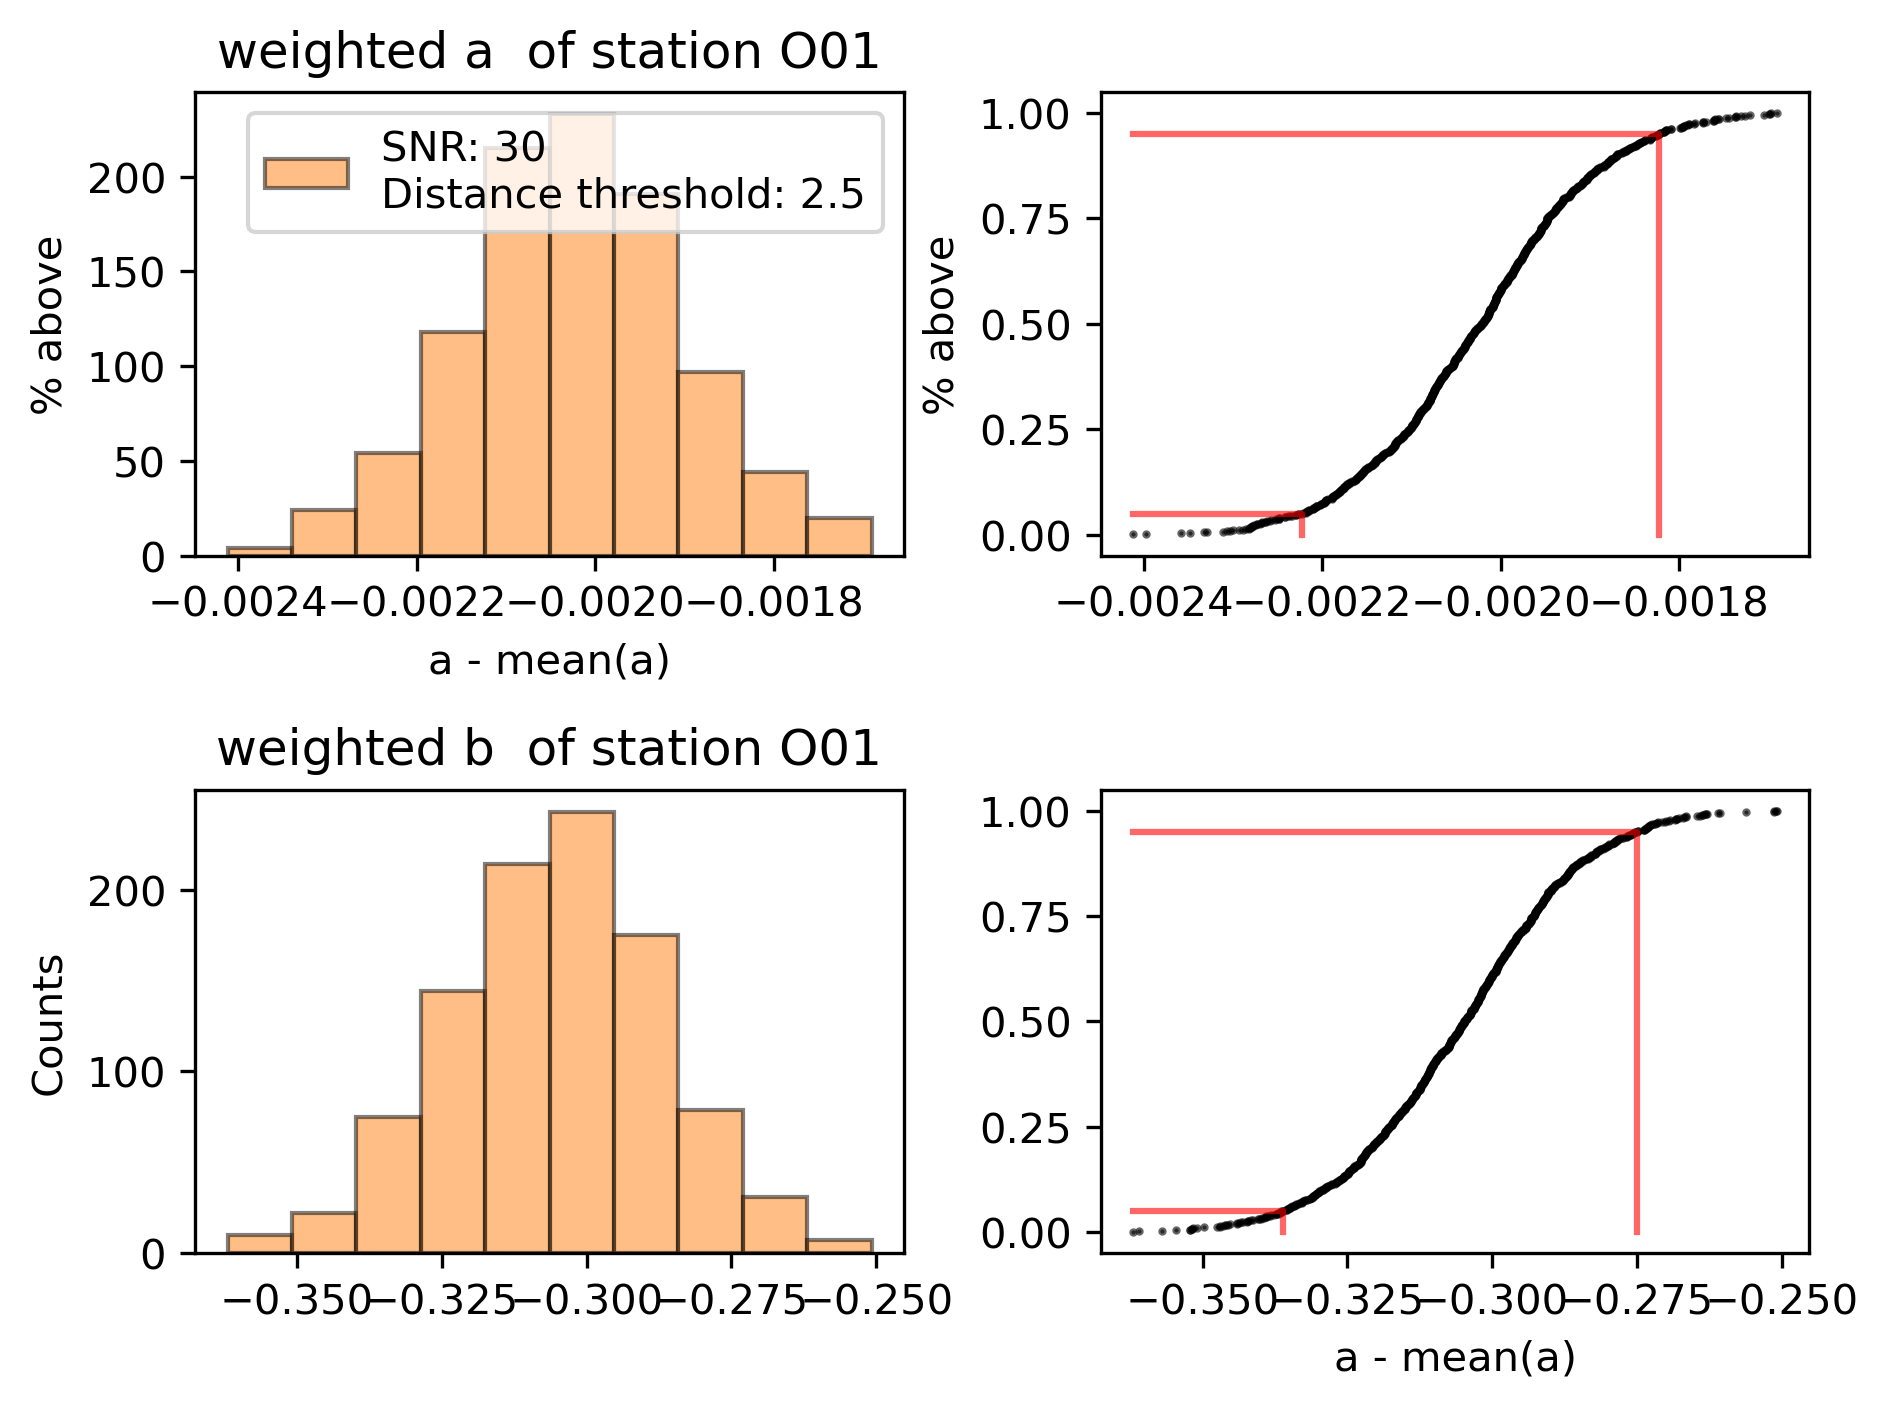

weighted a O02snr_trh_30__dist_trh_2.5
O02  confidence interval  0.05 :  -0.00333752135755
O02  confidence interval  0.95 :  -0.00246249697823
weighted b O02snr_trh_30__dist_trh_2.5
O02  confidence interval  0.05 :  -0.17213143647
O02  confidence interval  0.95 :  -0.0453230439076


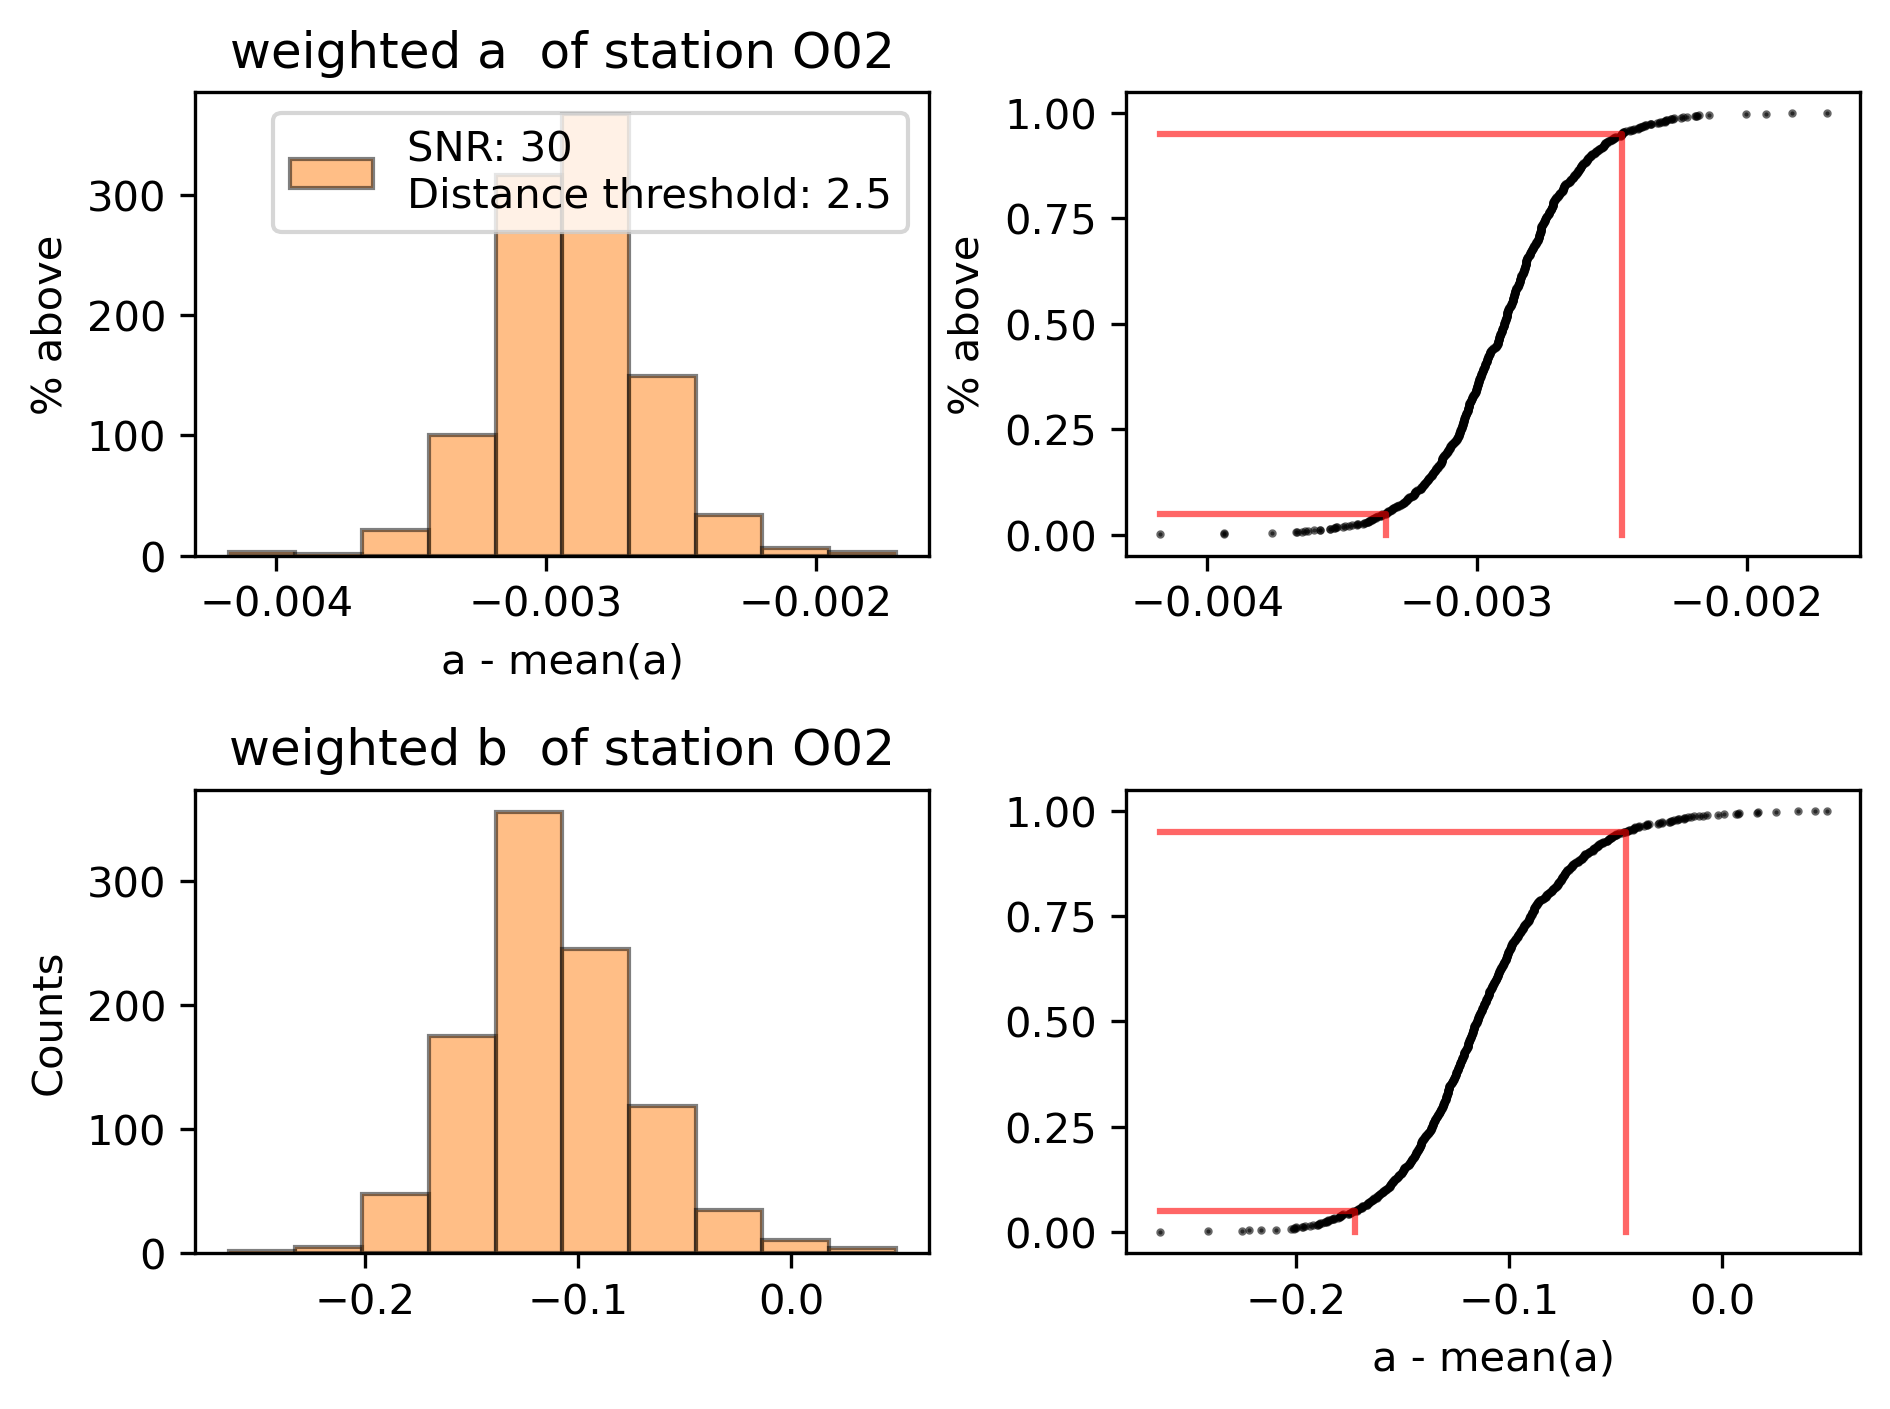

weighted a O03snr_trh_30__dist_trh_2.5
O03  confidence interval  0.05 :  -0.00249026937831
O03  confidence interval  0.95 :  -0.000395390070066
weighted b O03snr_trh_30__dist_trh_2.5
O03  confidence interval  0.05 :  -0.199697030983
O03  confidence interval  0.95 :  0.0512324095165


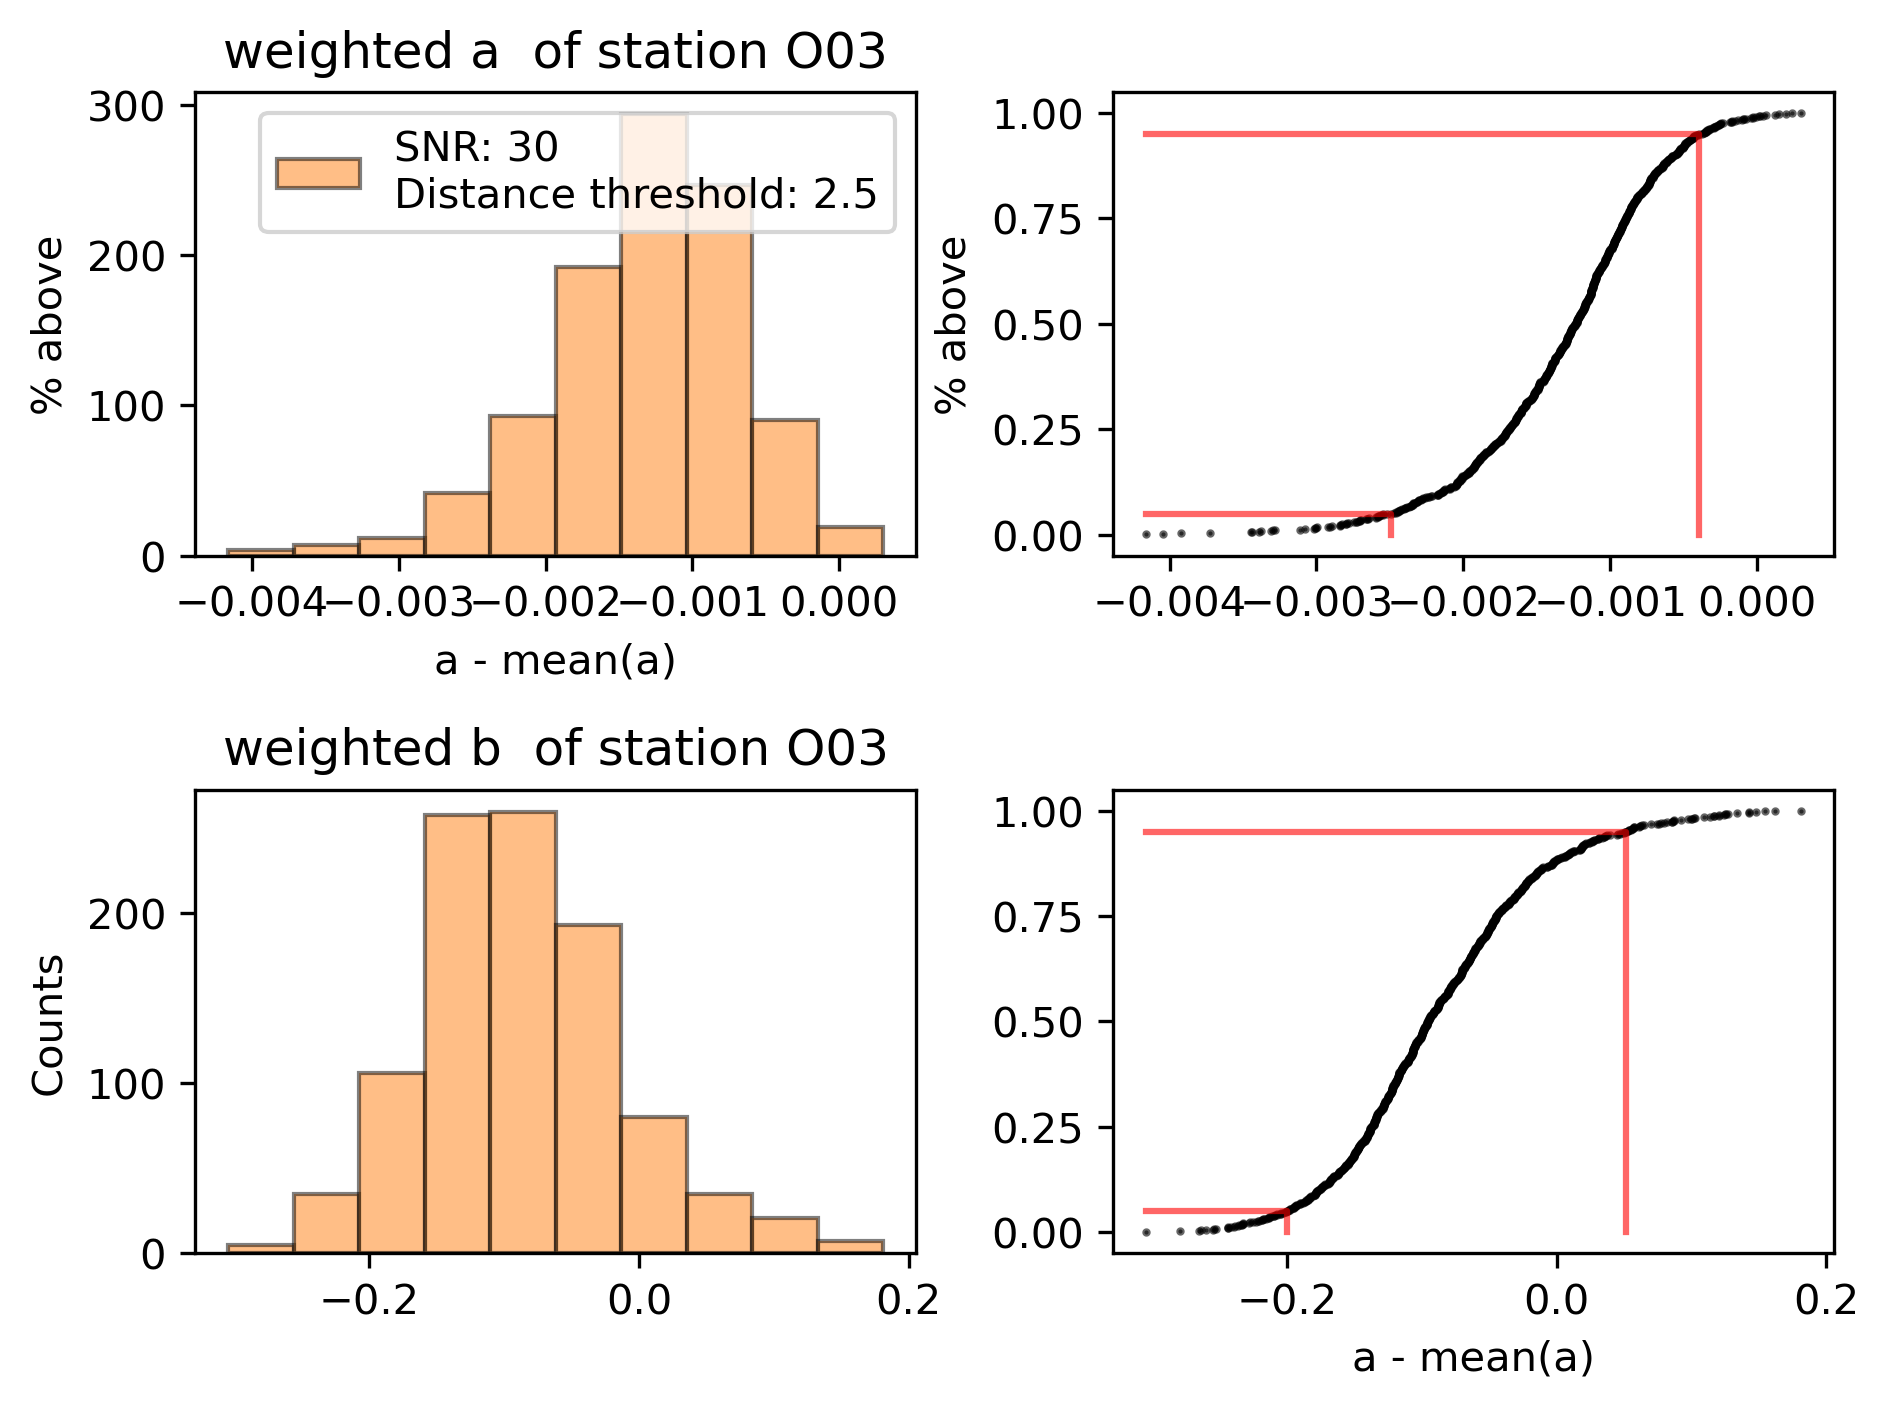

weighted a O04snr_trh_30__dist_trh_2.5
O04  confidence interval  0.05 :  -0.0028650753665
O04  confidence interval  0.95 :  -0.00150675723433
weighted b O04snr_trh_30__dist_trh_2.5
O04  confidence interval  0.05 :  -0.287123705366
O04  confidence interval  0.95 :  -0.0941020870469


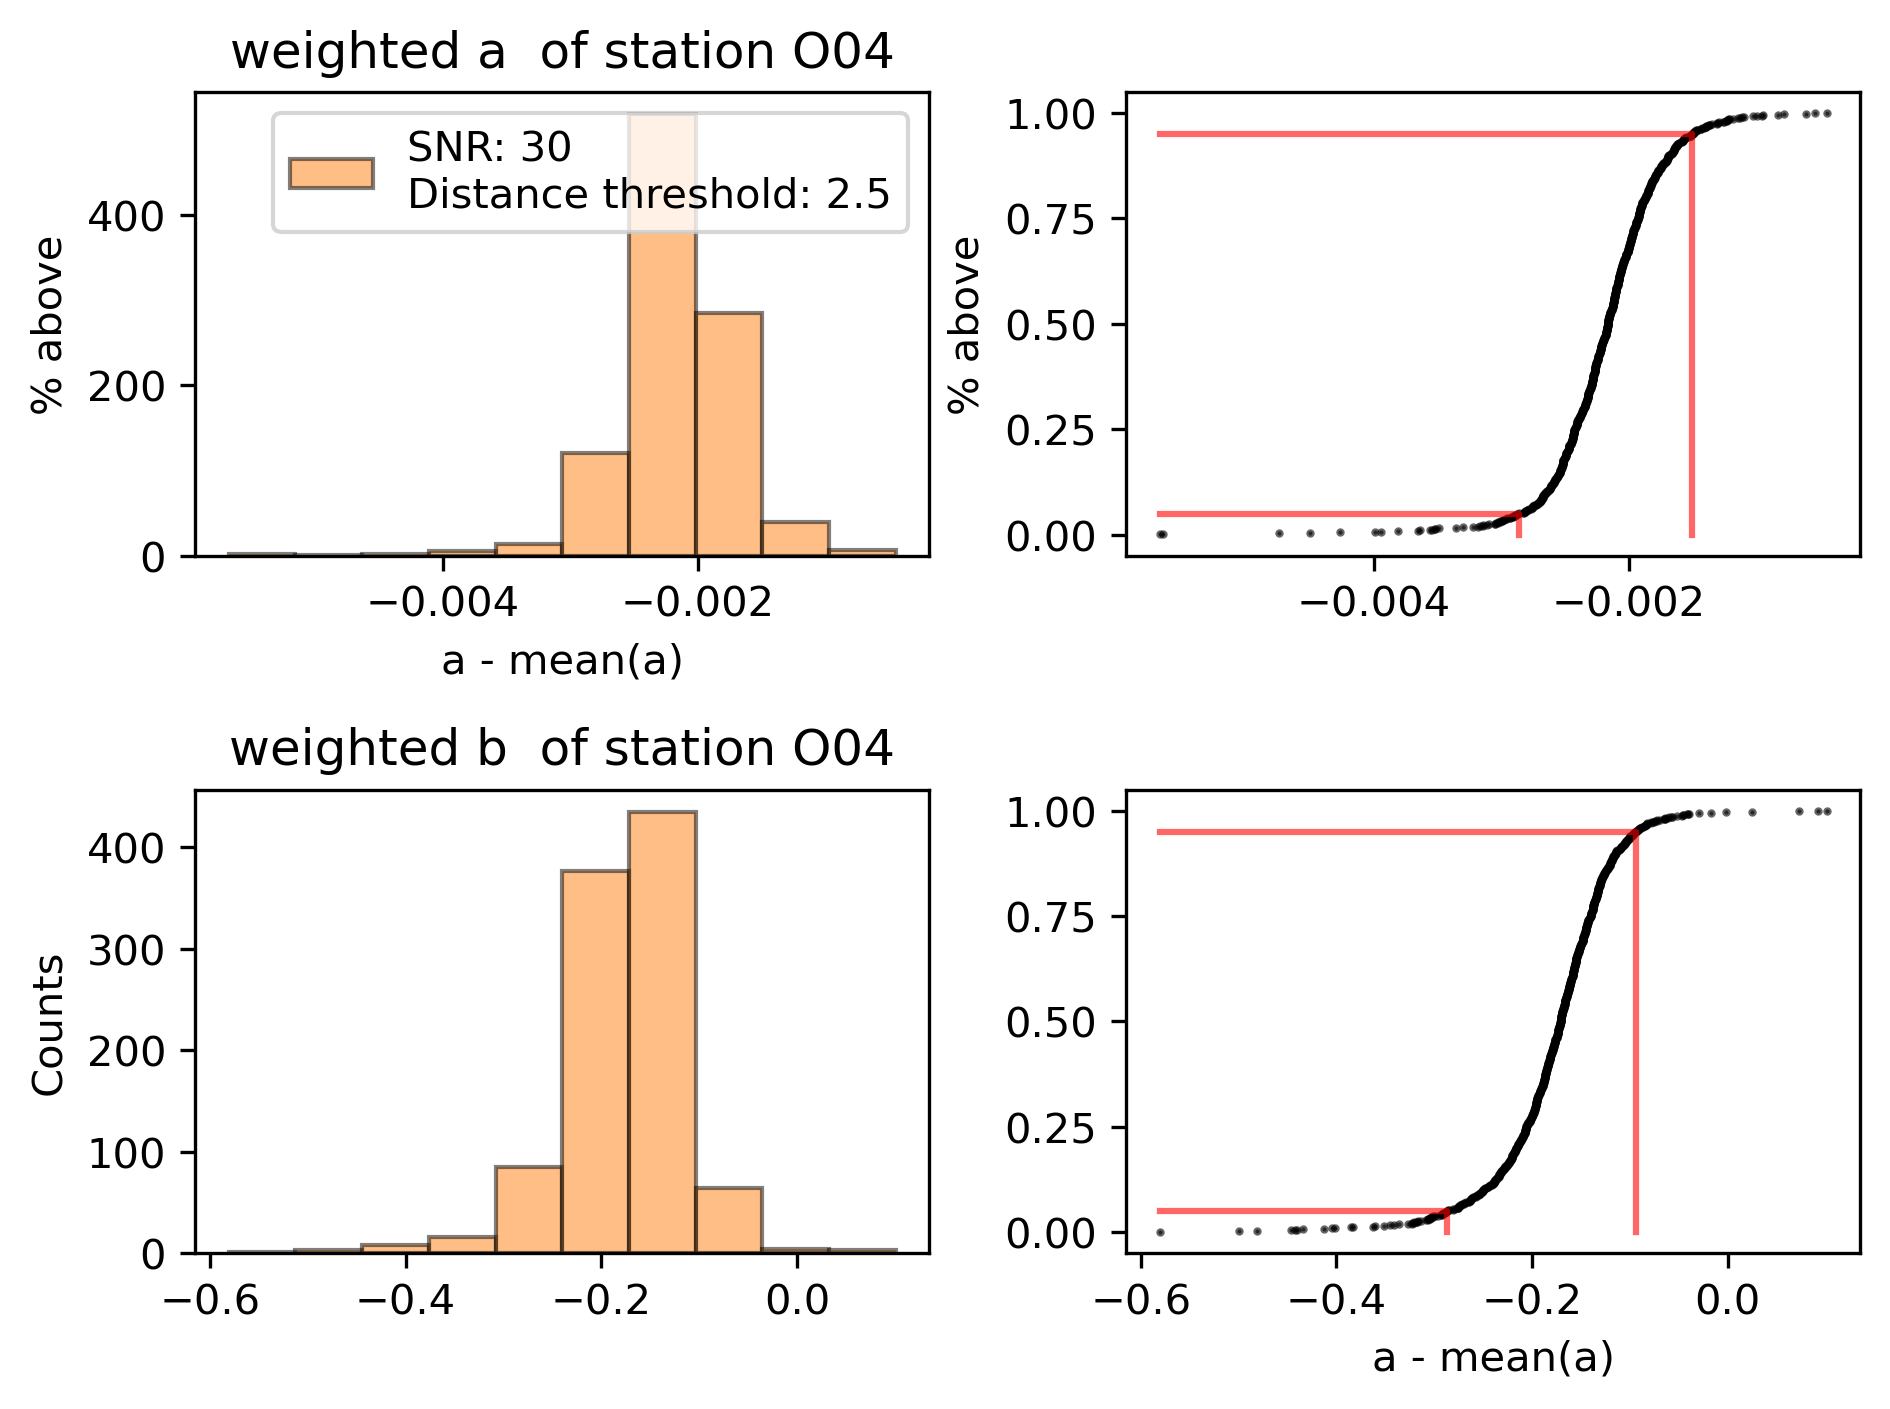

weighted a O06snr_trh_30__dist_trh_2.5
O06  confidence interval  0.05 :  -0.00116829933245
O06  confidence interval  0.95 :  0.000207106925506
weighted b O06snr_trh_30__dist_trh_2.5
O06  confidence interval  0.05 :  -0.274985730411
O06  confidence interval  0.95 :  -0.0513601610265


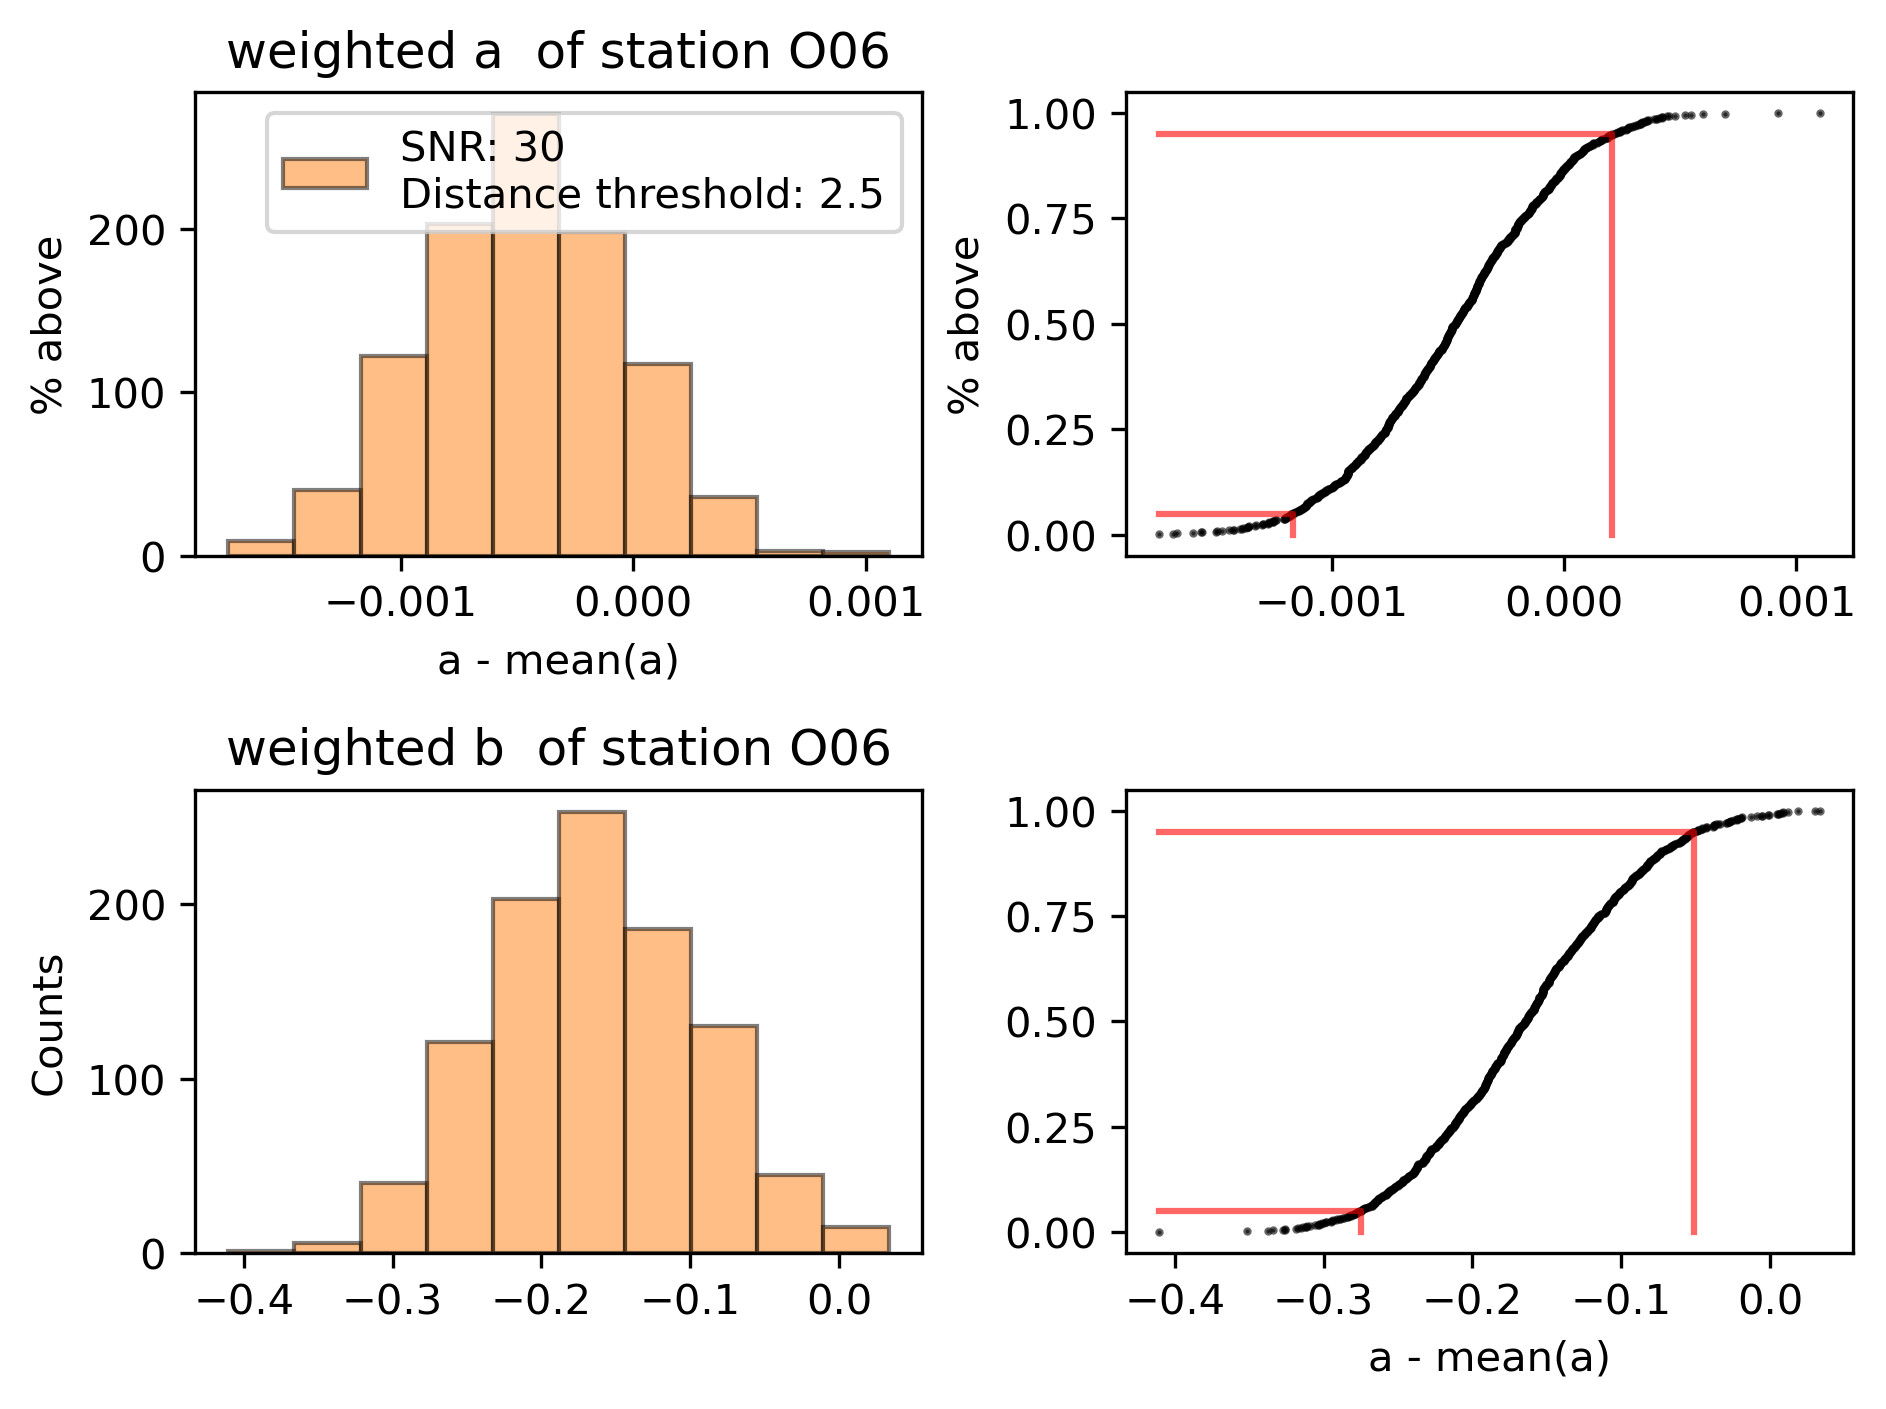

weighted a O08snr_trh_30__dist_trh_2.5
O08  confidence interval  0.05 :  -0.00138122833787
O08  confidence interval  0.95 :  0.00112264518132
weighted b O08snr_trh_30__dist_trh_2.5
O08  confidence interval  0.05 :  -0.444130674024
O08  confidence interval  0.95 :  -0.166564633661


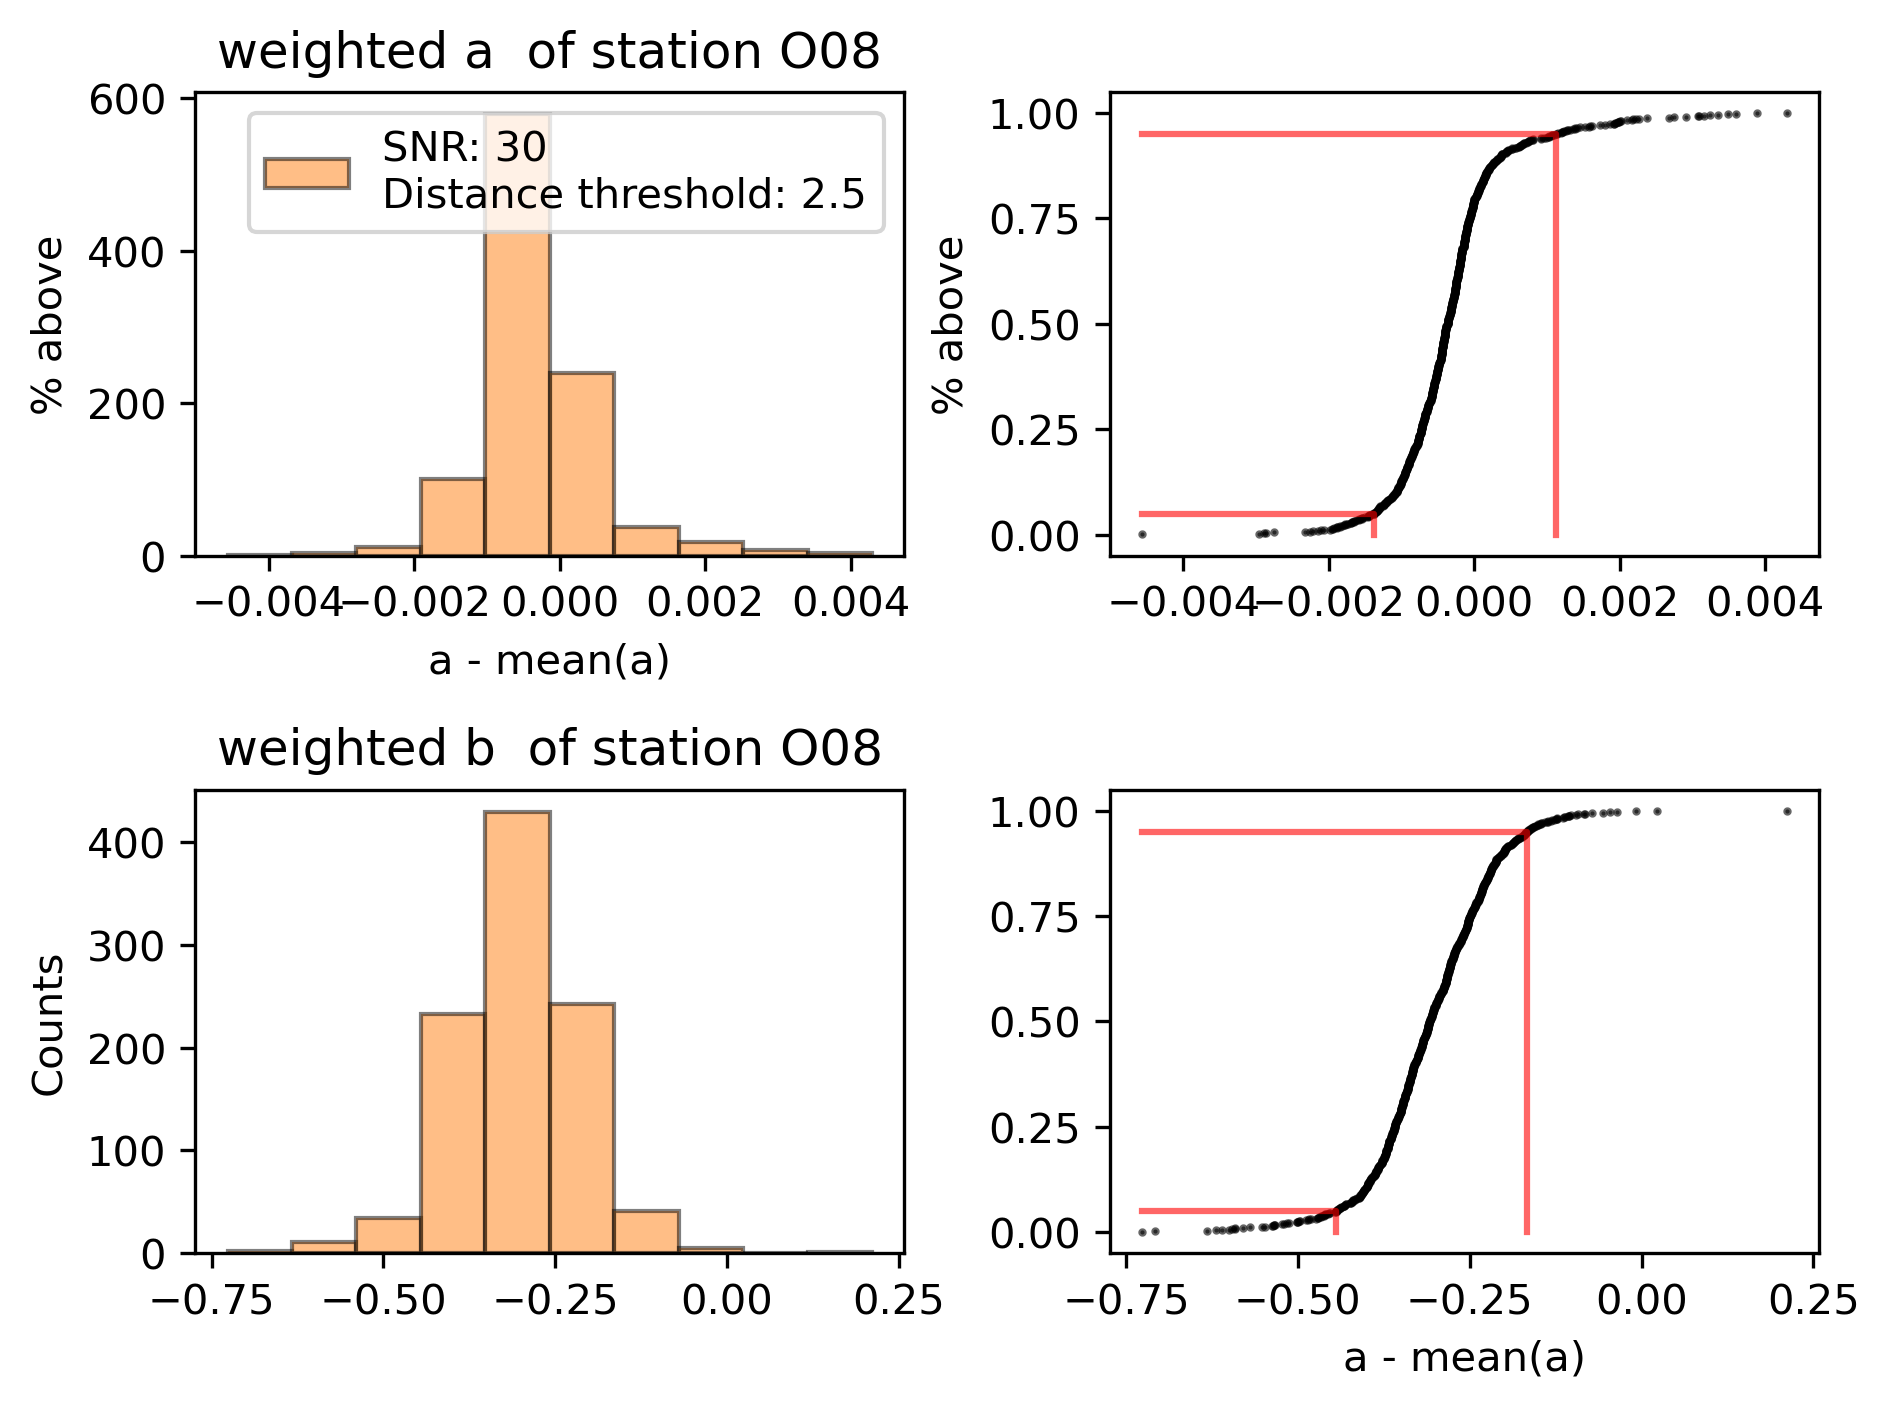

weighted a O10snr_trh_30__dist_trh_2.5
O10  confidence interval  0.05 :  -0.00344886599162
O10  confidence interval  0.95 :  -0.00279926282471
weighted b O10snr_trh_30__dist_trh_2.5
O10  confidence interval  0.05 :  -0.249749050248
O10  confidence interval  0.95 :  -0.174350082732


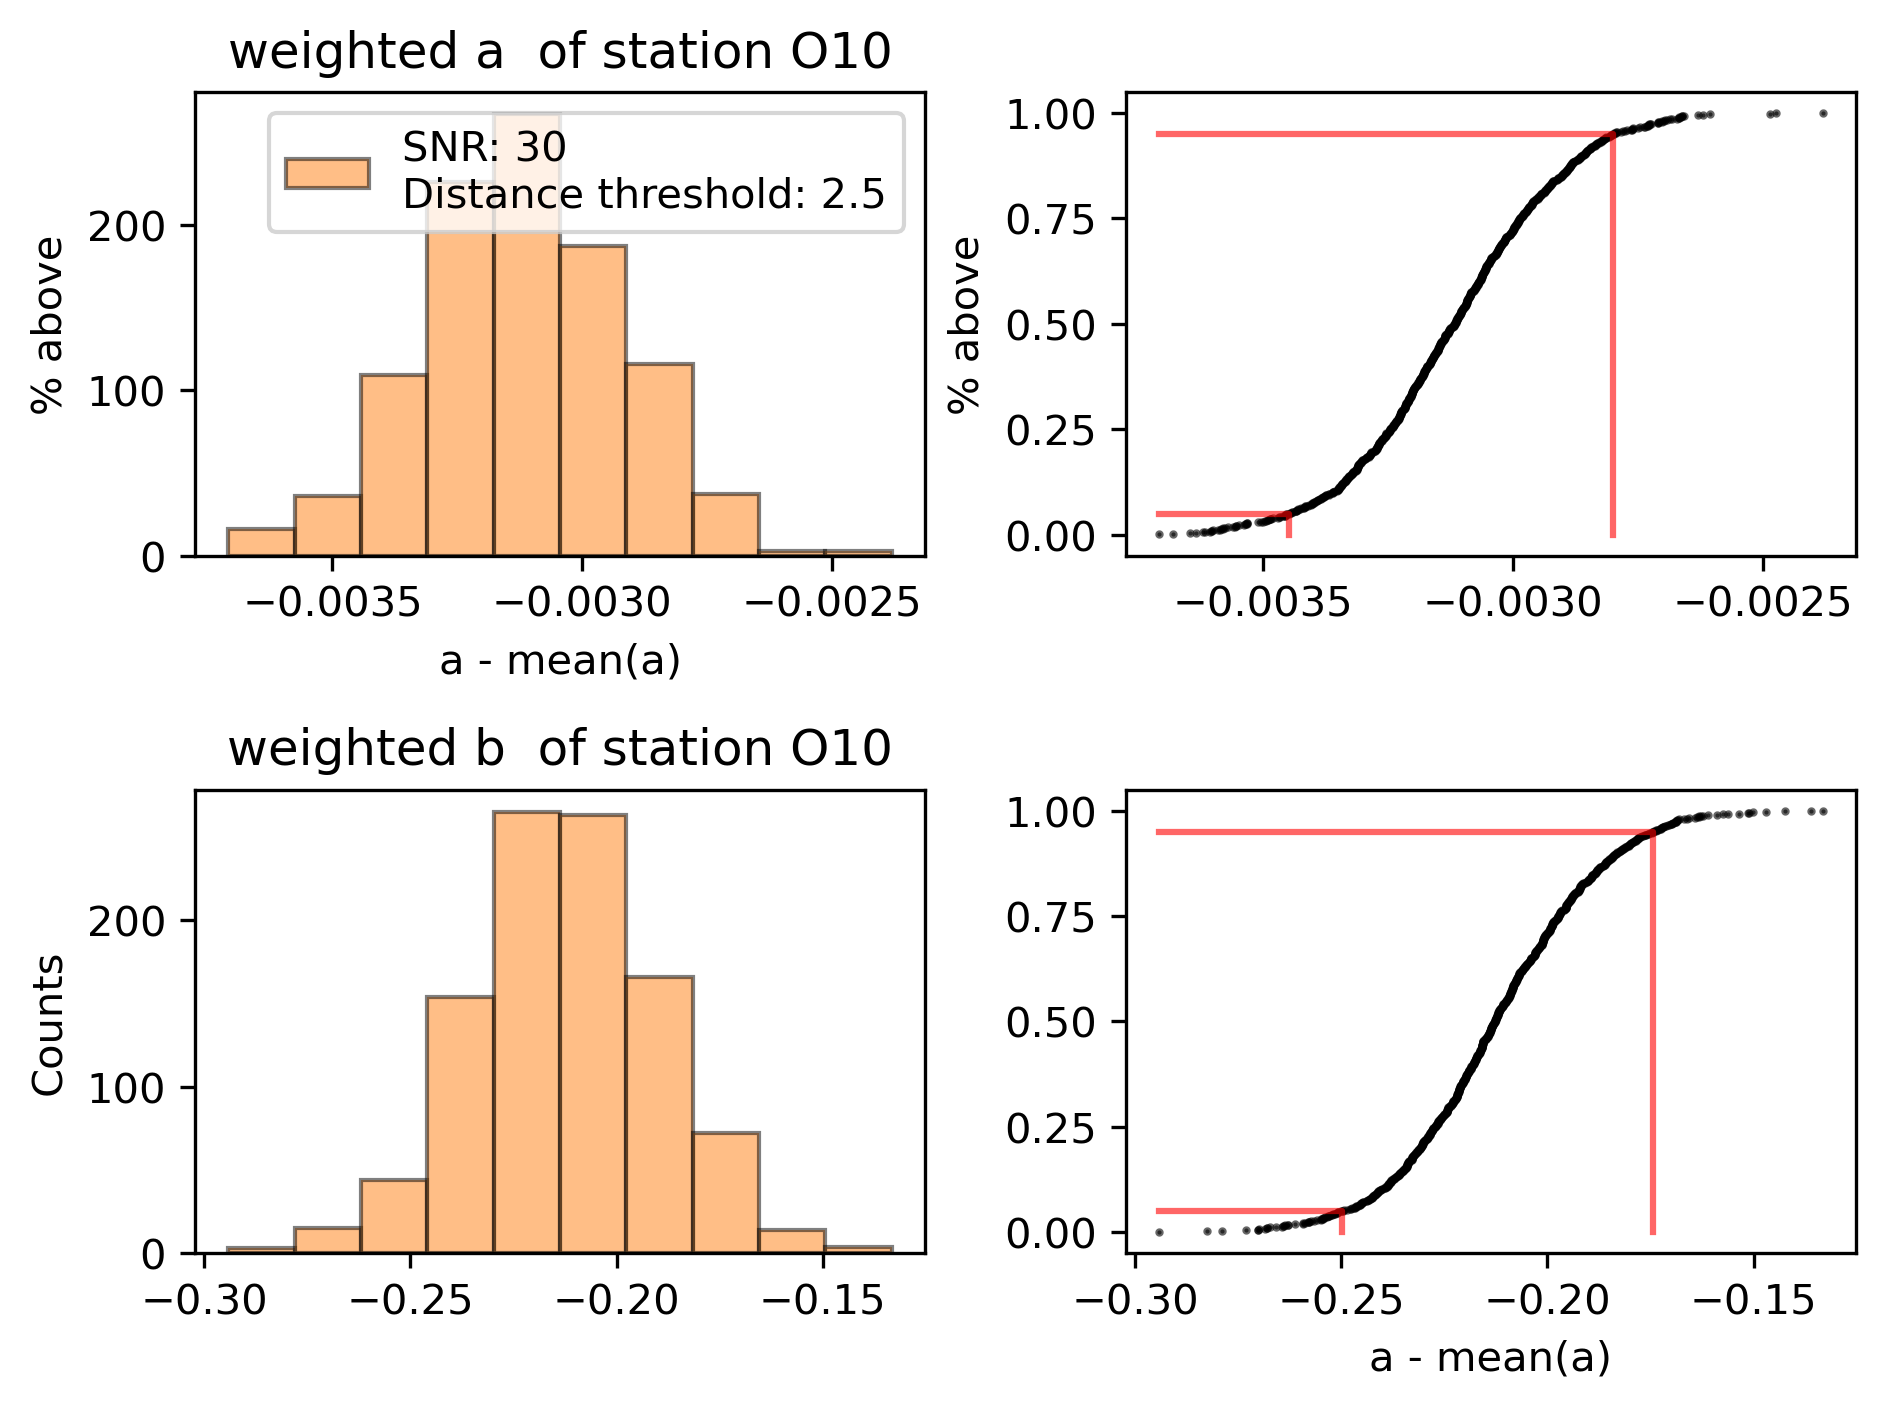

weighted a O11snr_trh_30__dist_trh_2.5
O11  confidence interval  0.05 :  -0.00279532446012
O11  confidence interval  0.95 :  -0.00116934315318
weighted b O11snr_trh_30__dist_trh_2.5
O11  confidence interval  0.05 :  -0.511875350295
O11  confidence interval  0.95 :  -0.252402535071


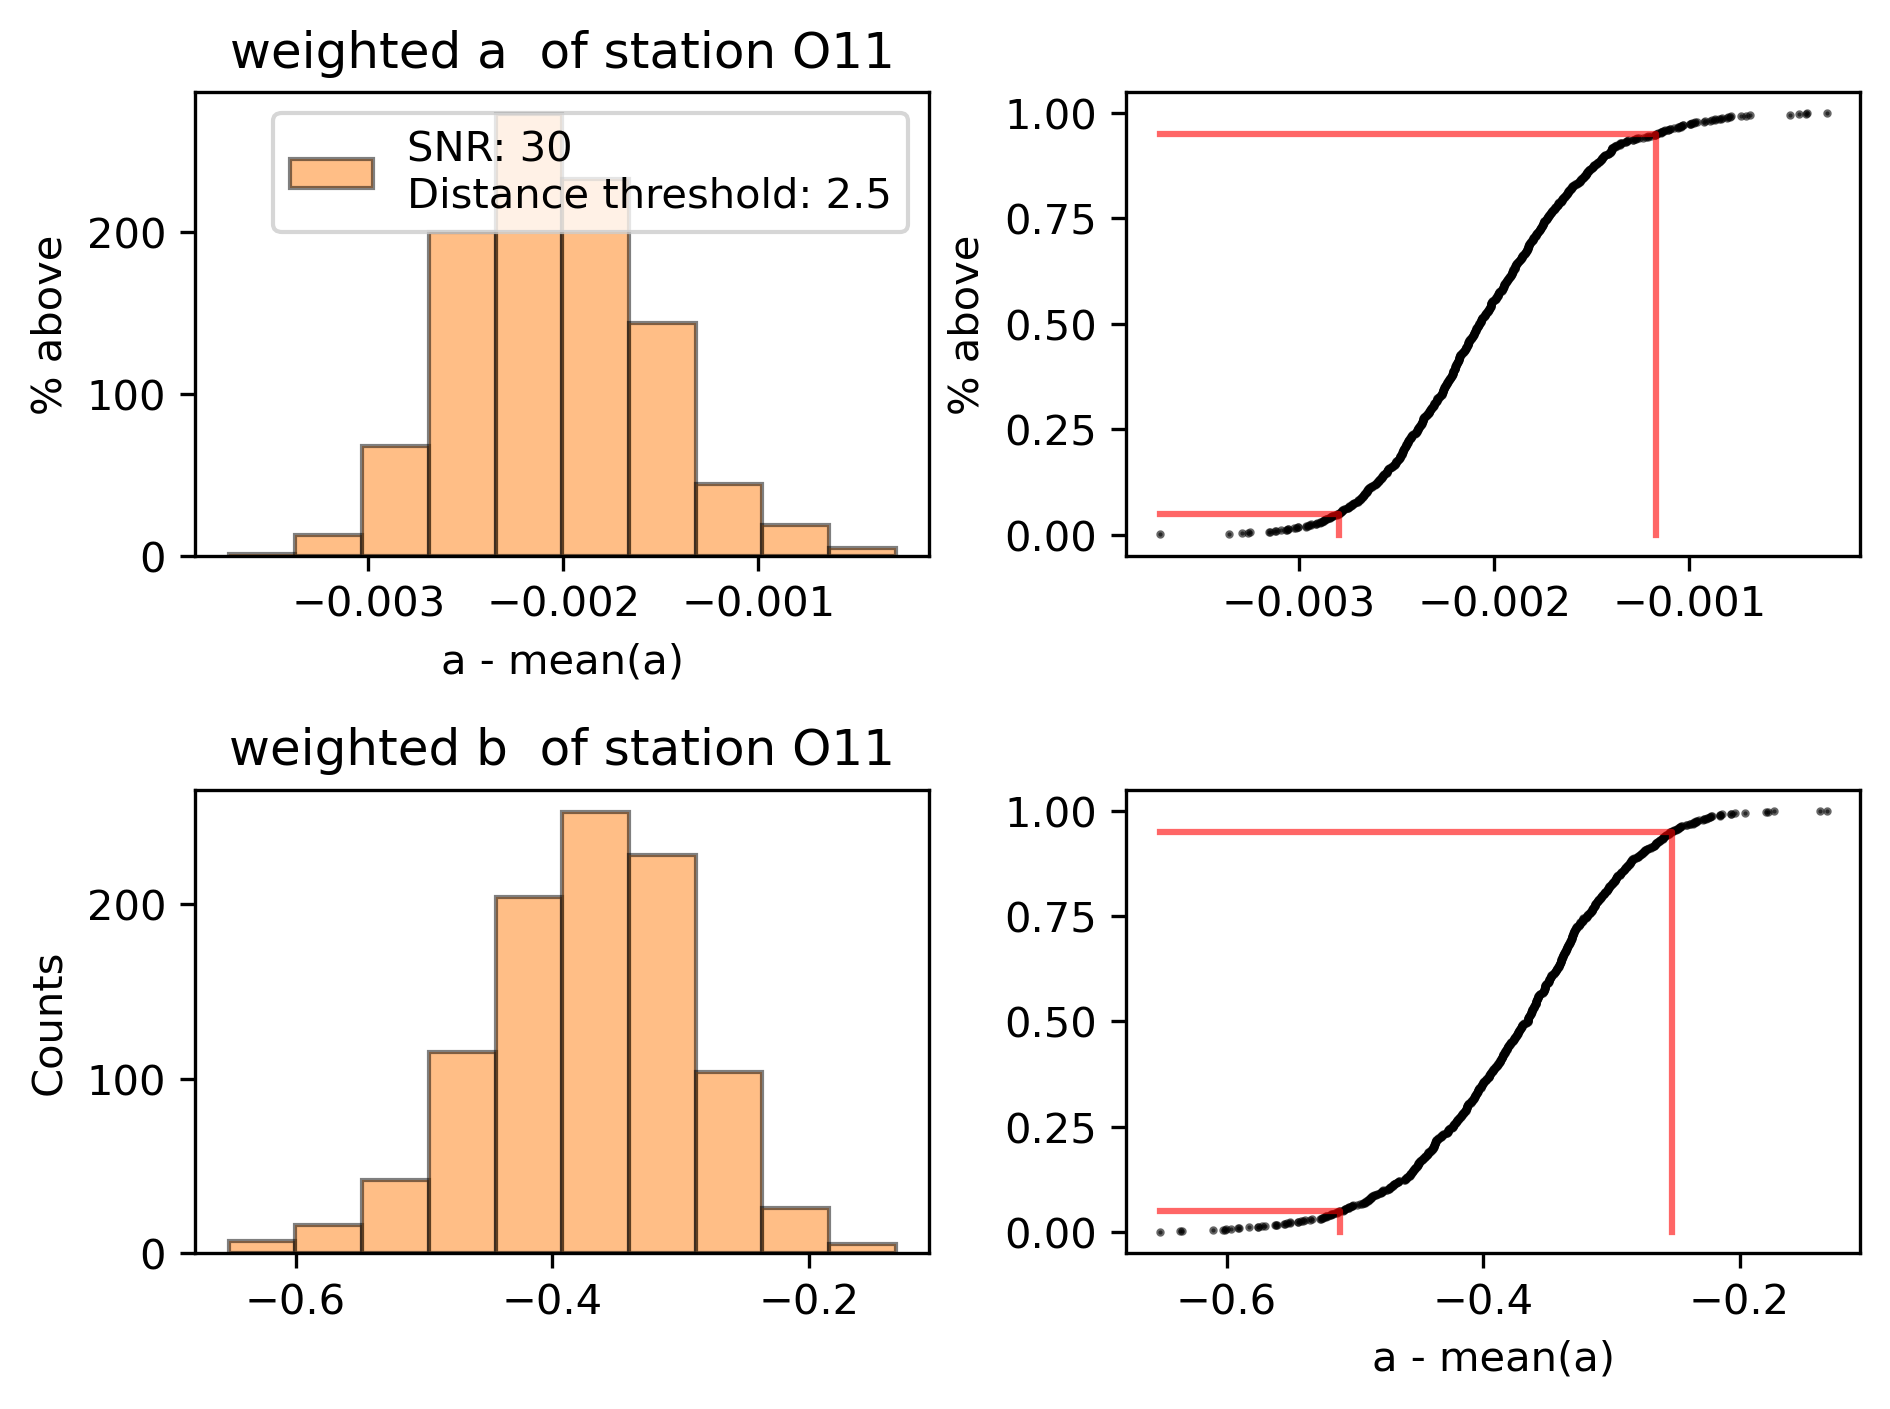

weighted a O14snr_trh_30__dist_trh_2.5
O14  confidence interval  0.05 :  -0.00166889354678
O14  confidence interval  0.95 :  -0.000438955726956
weighted b O14snr_trh_30__dist_trh_2.5
O14  confidence interval  0.05 :  -0.280361066365
O14  confidence interval  0.95 :  -0.132498487625


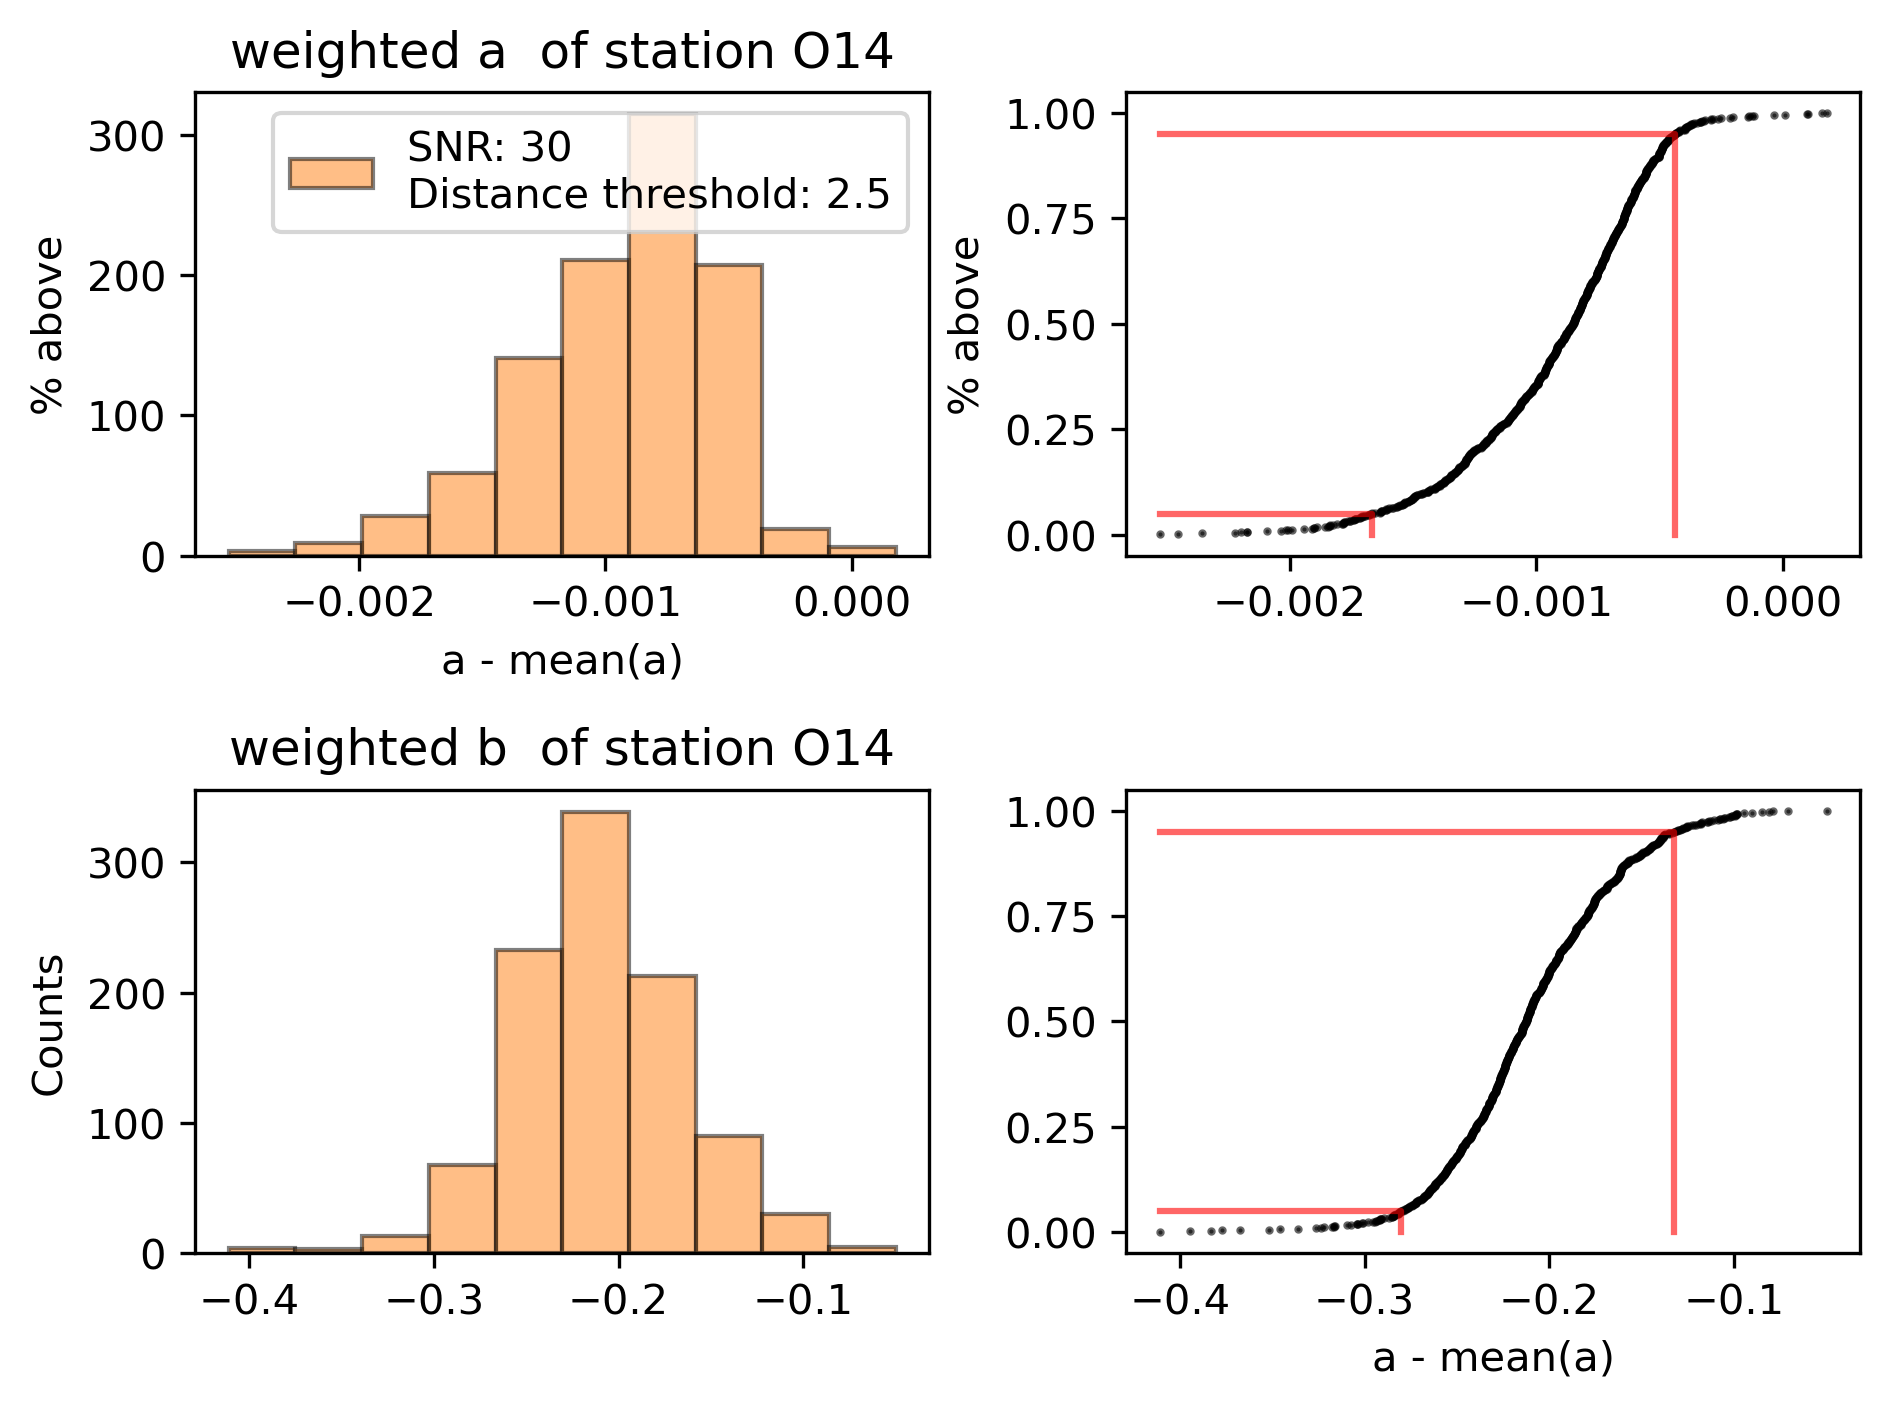

weighted a O15snr_trh_30__dist_trh_2.5
O15  confidence interval  0.05 :  -0.00541242610355
O15  confidence interval  0.95 :  -0.00227176206887
weighted b O15snr_trh_30__dist_trh_2.5
O15  confidence interval  0.05 :  -0.718048249299
O15  confidence interval  0.95 :  -0.0621638263482


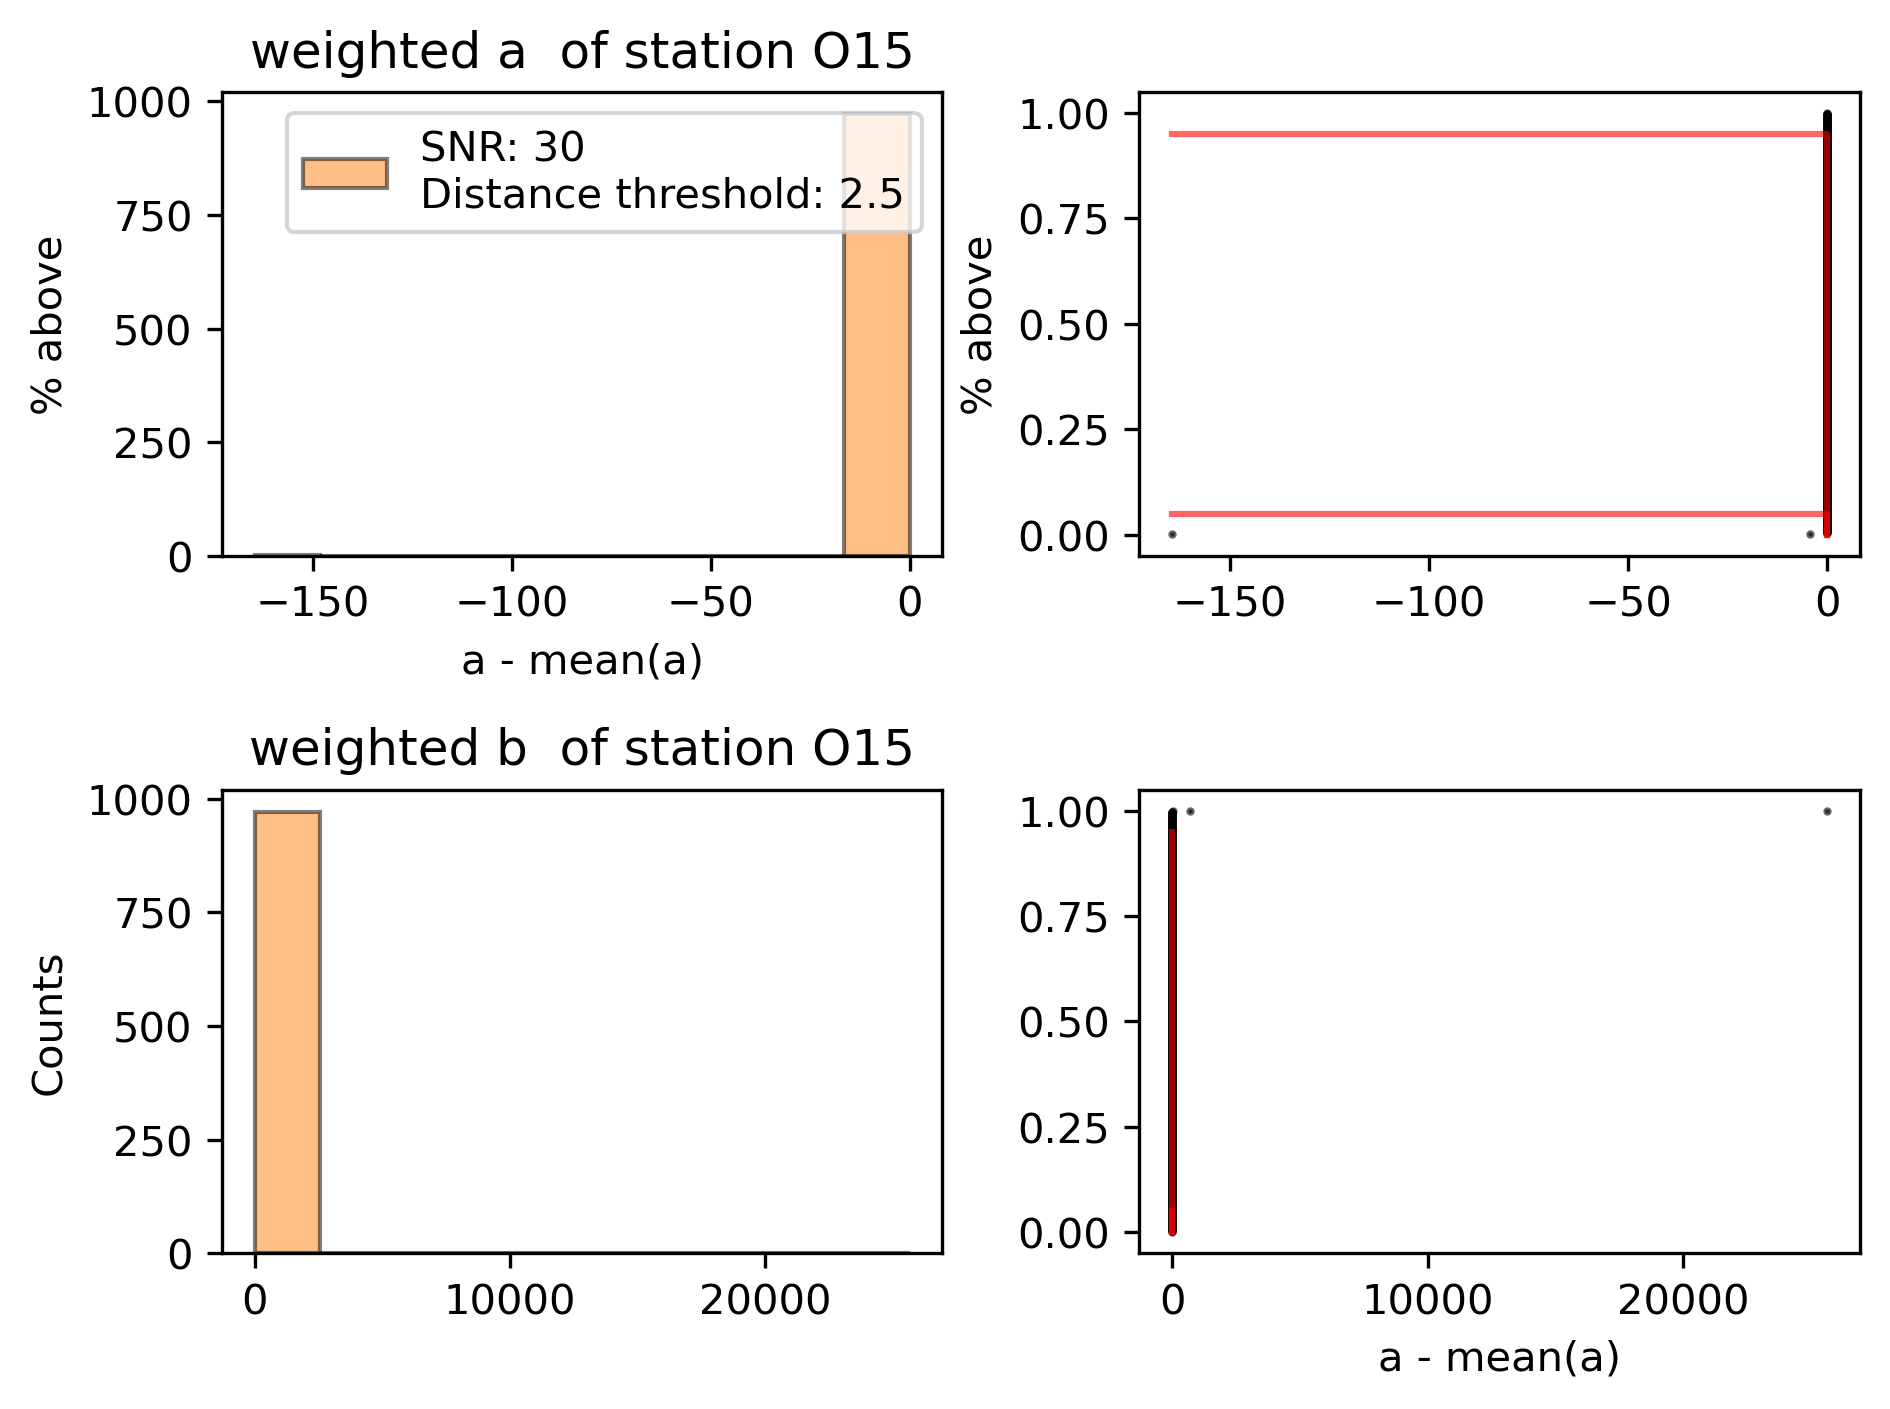

weighted a O16snr_trh_30__dist_trh_2.5
O16  confidence interval  0.05 :  -0.00268900140464
O16  confidence interval  0.95 :  -0.00155345953304
weighted b O16snr_trh_30__dist_trh_2.5
O16  confidence interval  0.05 :  -0.267227209671
O16  confidence interval  0.95 :  -0.124296517255


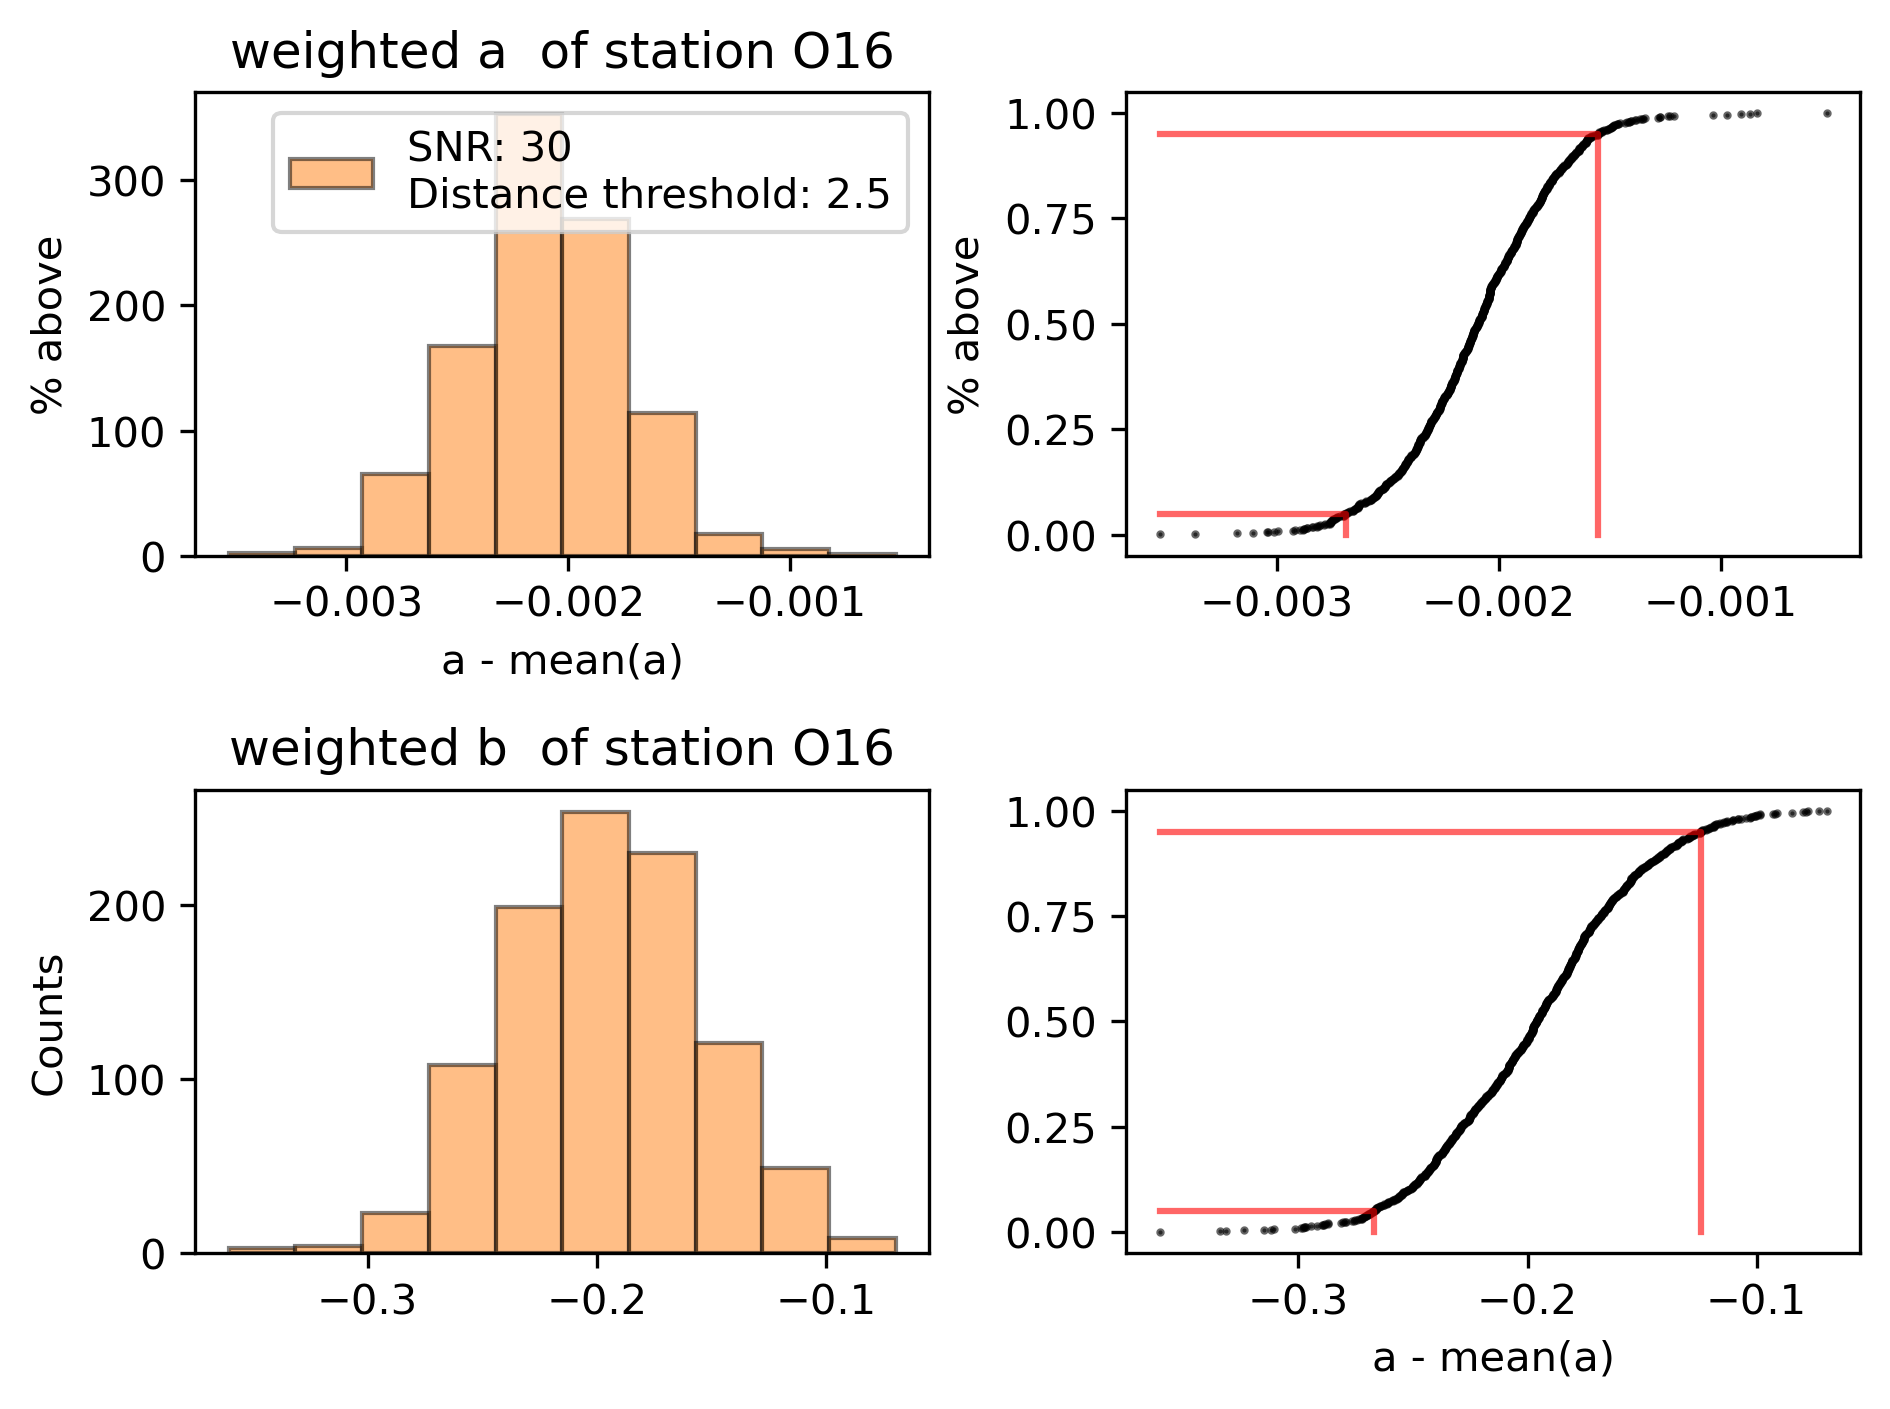

weighted a O17snr_trh_30__dist_trh_2.5
O17  confidence interval  0.05 :  -0.00166869652624
O17  confidence interval  0.95 :  -0.00134900458127
weighted b O17snr_trh_30__dist_trh_2.5
O17  confidence interval  0.05 :  -0.189404317497
O17  confidence interval  0.95 :  -0.134085804574


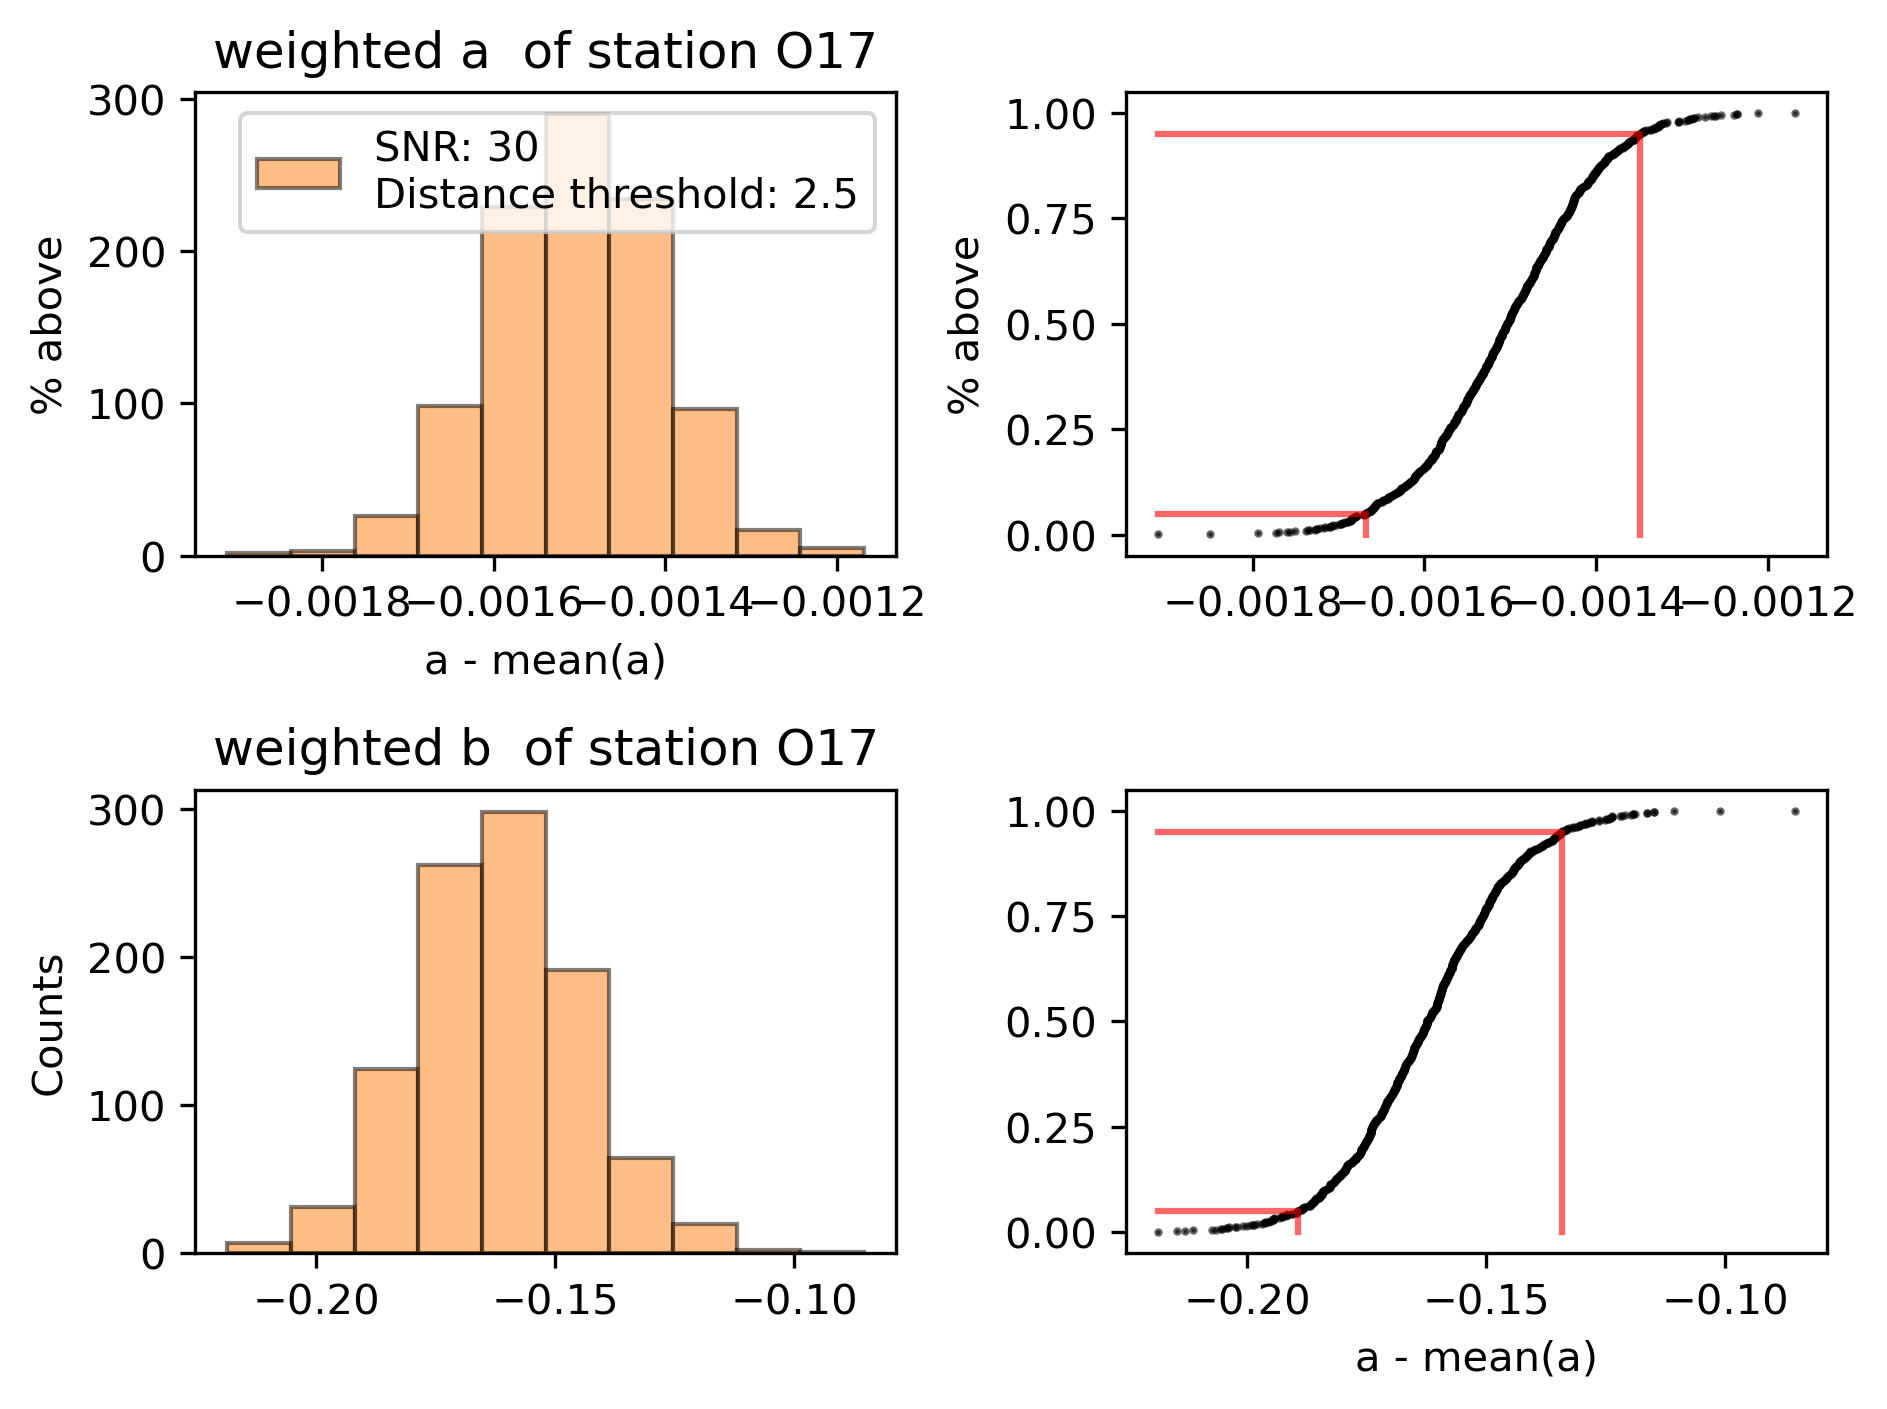

weighted a O19snr_trh_30__dist_trh_2.5
O19  confidence interval  0.05 :  -0.00326193747327
O19  confidence interval  0.95 :  -0.0023331123622
weighted b O19snr_trh_30__dist_trh_2.5
O19  confidence interval  0.05 :  -0.435527185947
O19  confidence interval  0.95 :  -0.288495294151


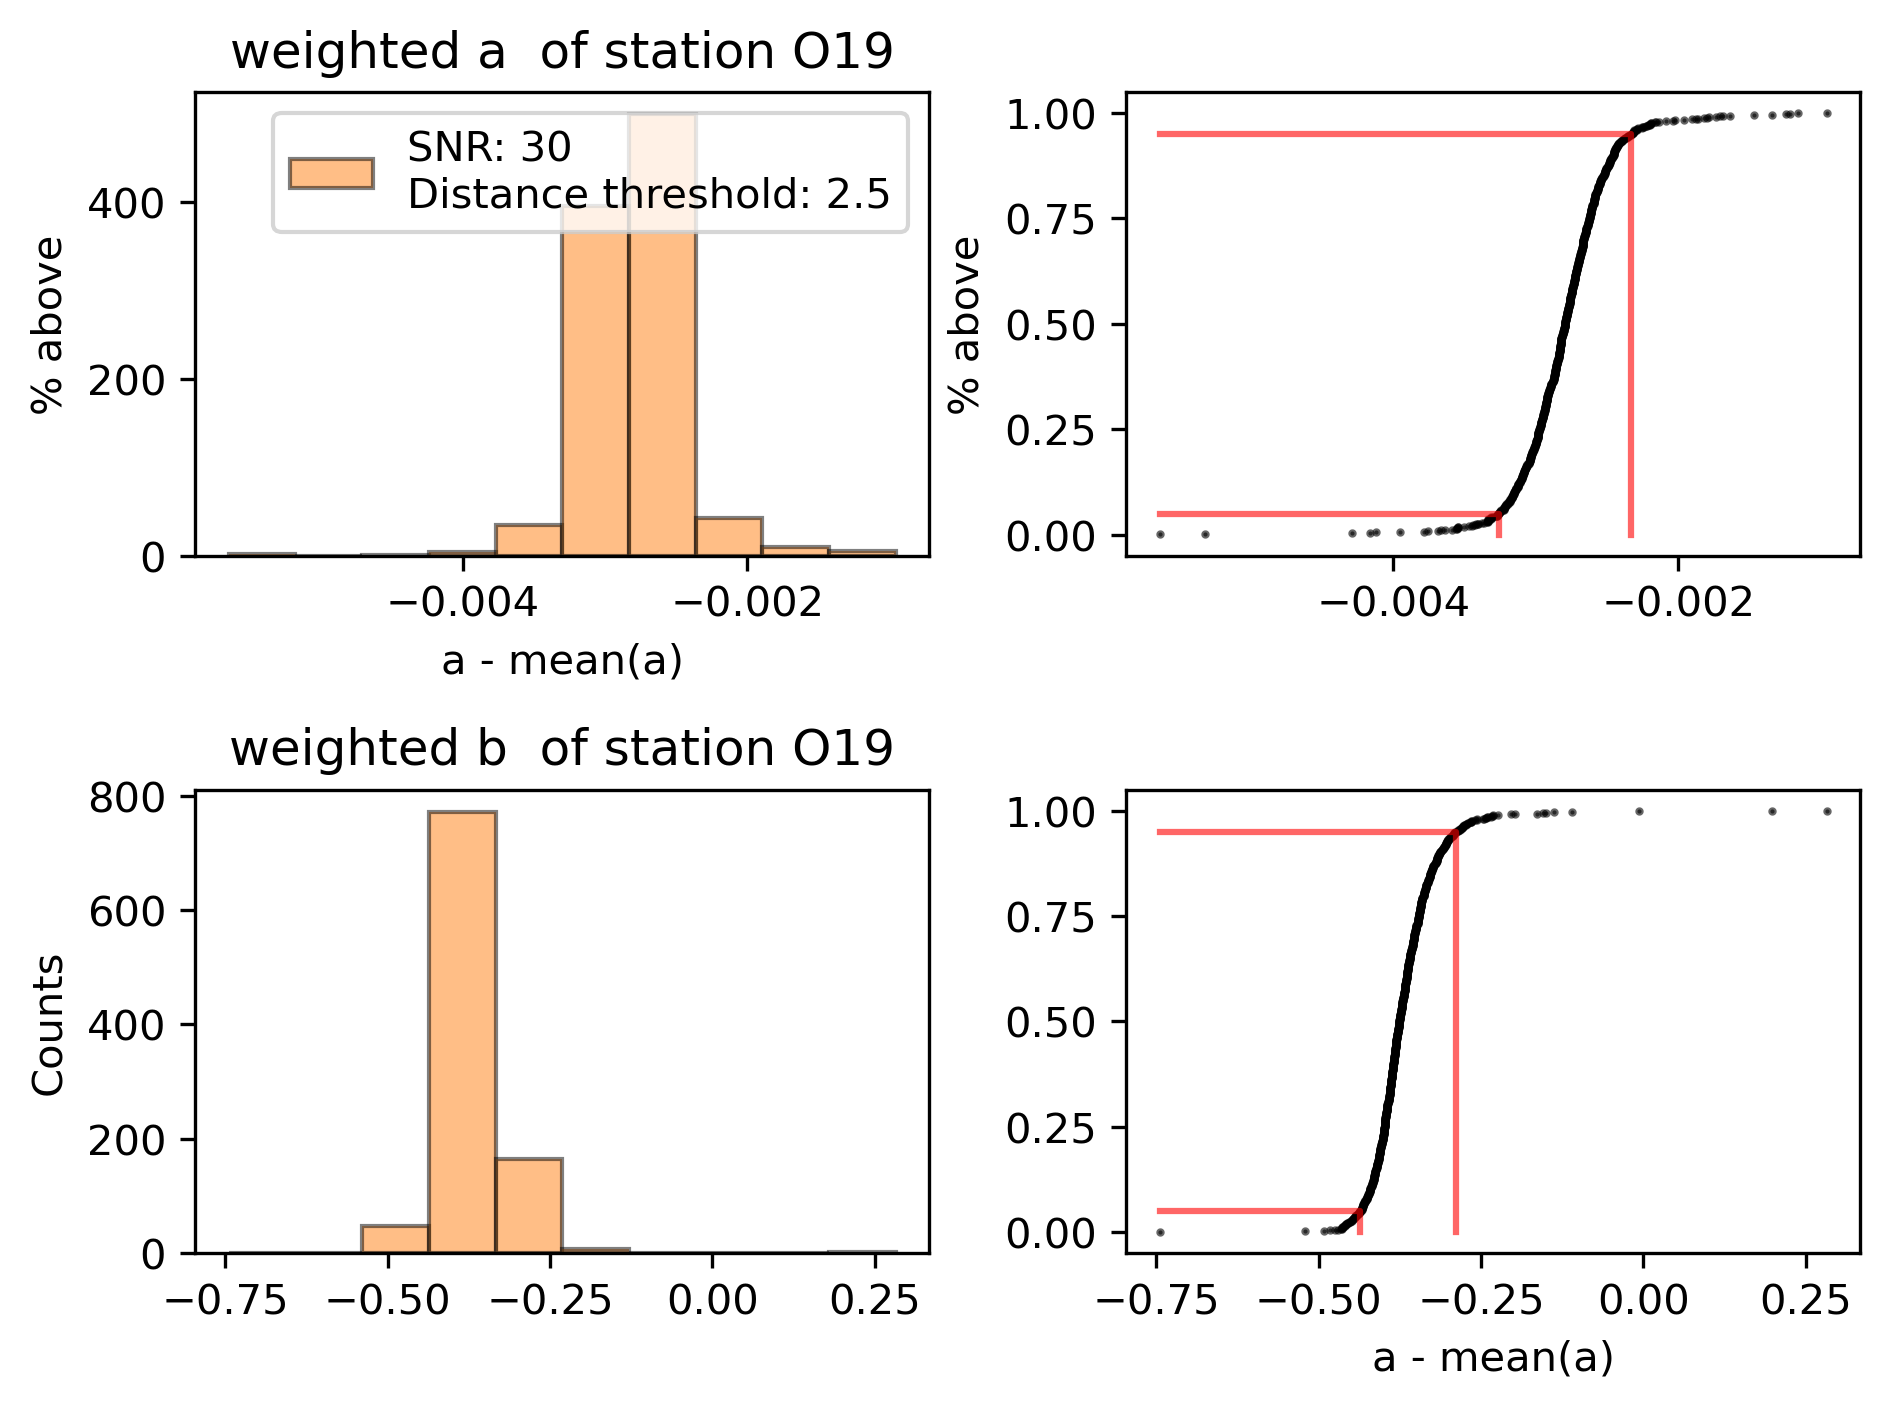

weighted a O20snr_trh_30__dist_trh_2.5
O20  confidence interval  0.05 :  -0.0136420971248
O20  confidence interval  0.95 :  -0.0122226266112
weighted b O20snr_trh_30__dist_trh_2.5
O20  confidence interval  0.05 :  -0.0799839607941
O20  confidence interval  0.95 :  0.195439357348


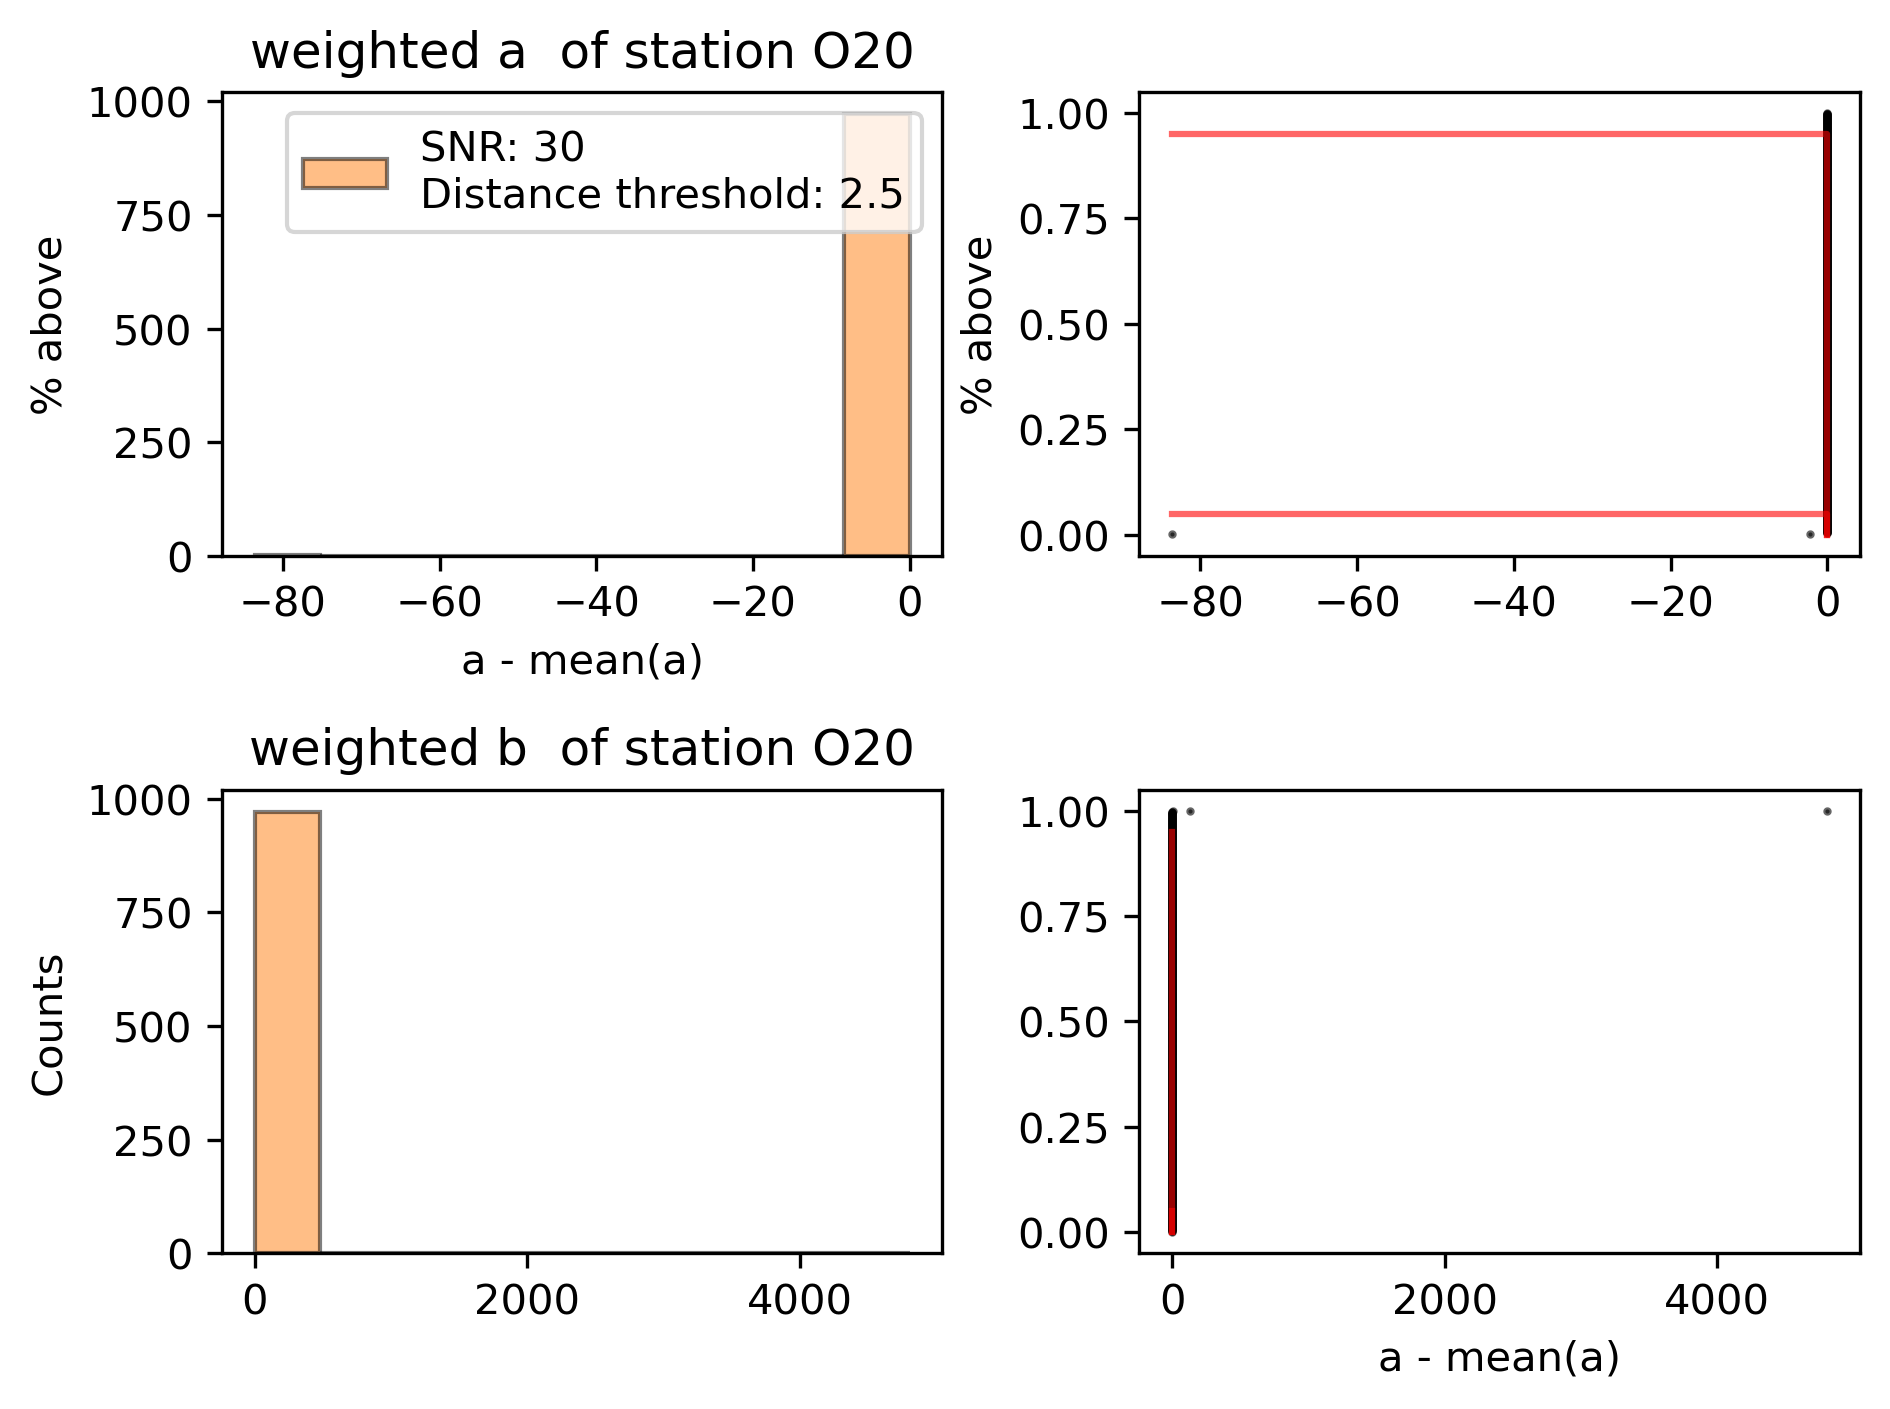

weighted a O21snr_trh_30__dist_trh_2.5
O21  confidence interval  0.05 :  -0.0039844654442
O21  confidence interval  0.95 :  -0.00274412517395
weighted b O21snr_trh_30__dist_trh_2.5
O21  confidence interval  0.05 :  -0.272383306217
O21  confidence interval  0.95 :  -0.110263034607


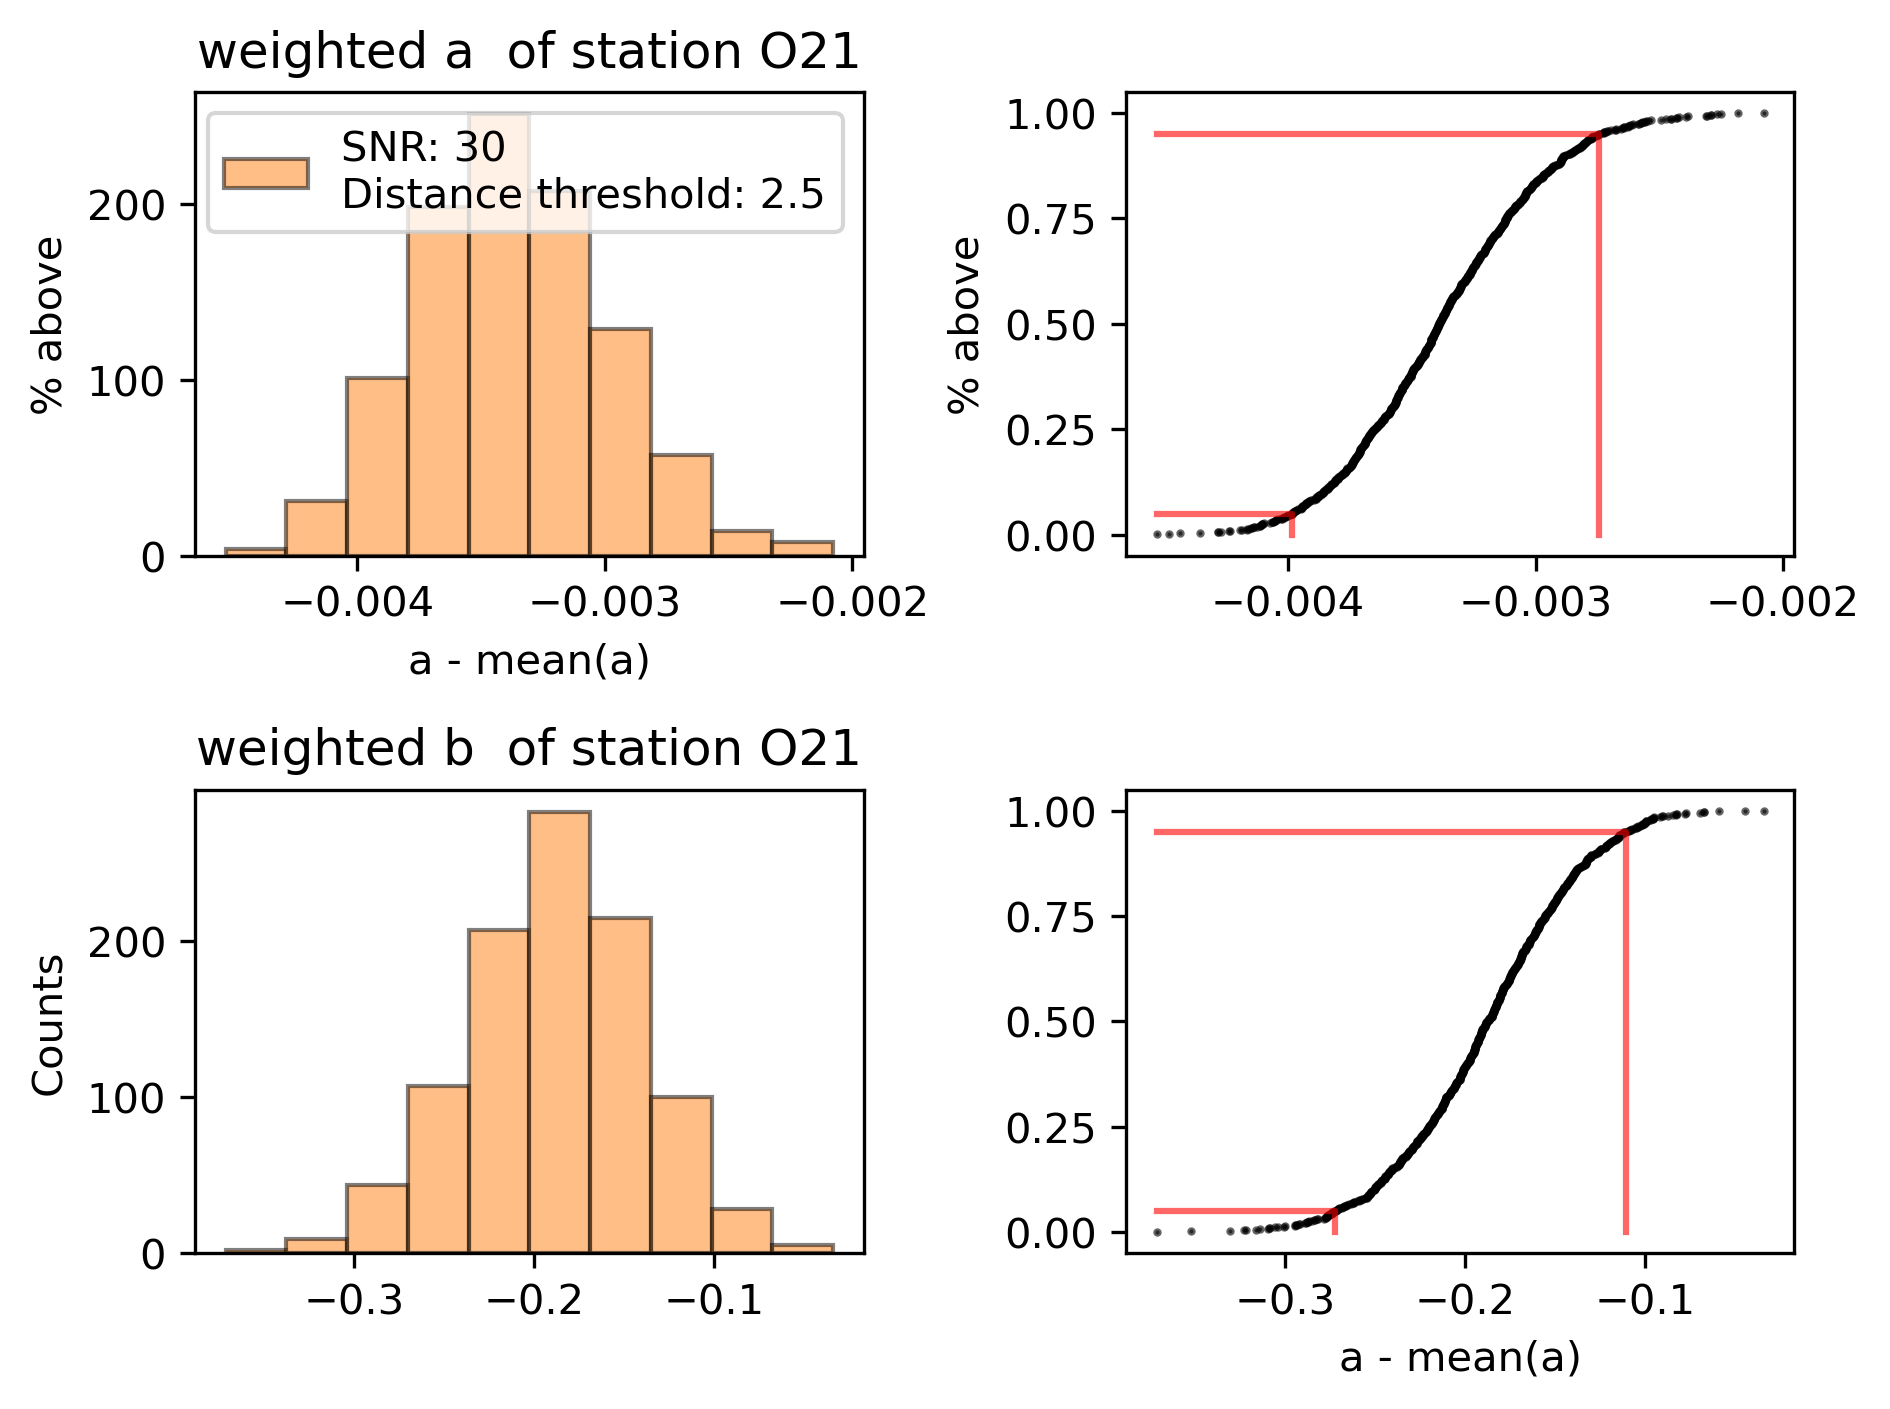

weighted a O22snr_trh_30__dist_trh_2.5
O22  confidence interval  0.05 :  -0.00157304682397
O22  confidence interval  0.95 :  -0.000877372774168
weighted b O22snr_trh_30__dist_trh_2.5
O22  confidence interval  0.05 :  -0.380919130237
O22  confidence interval  0.95 :  -0.229891834028


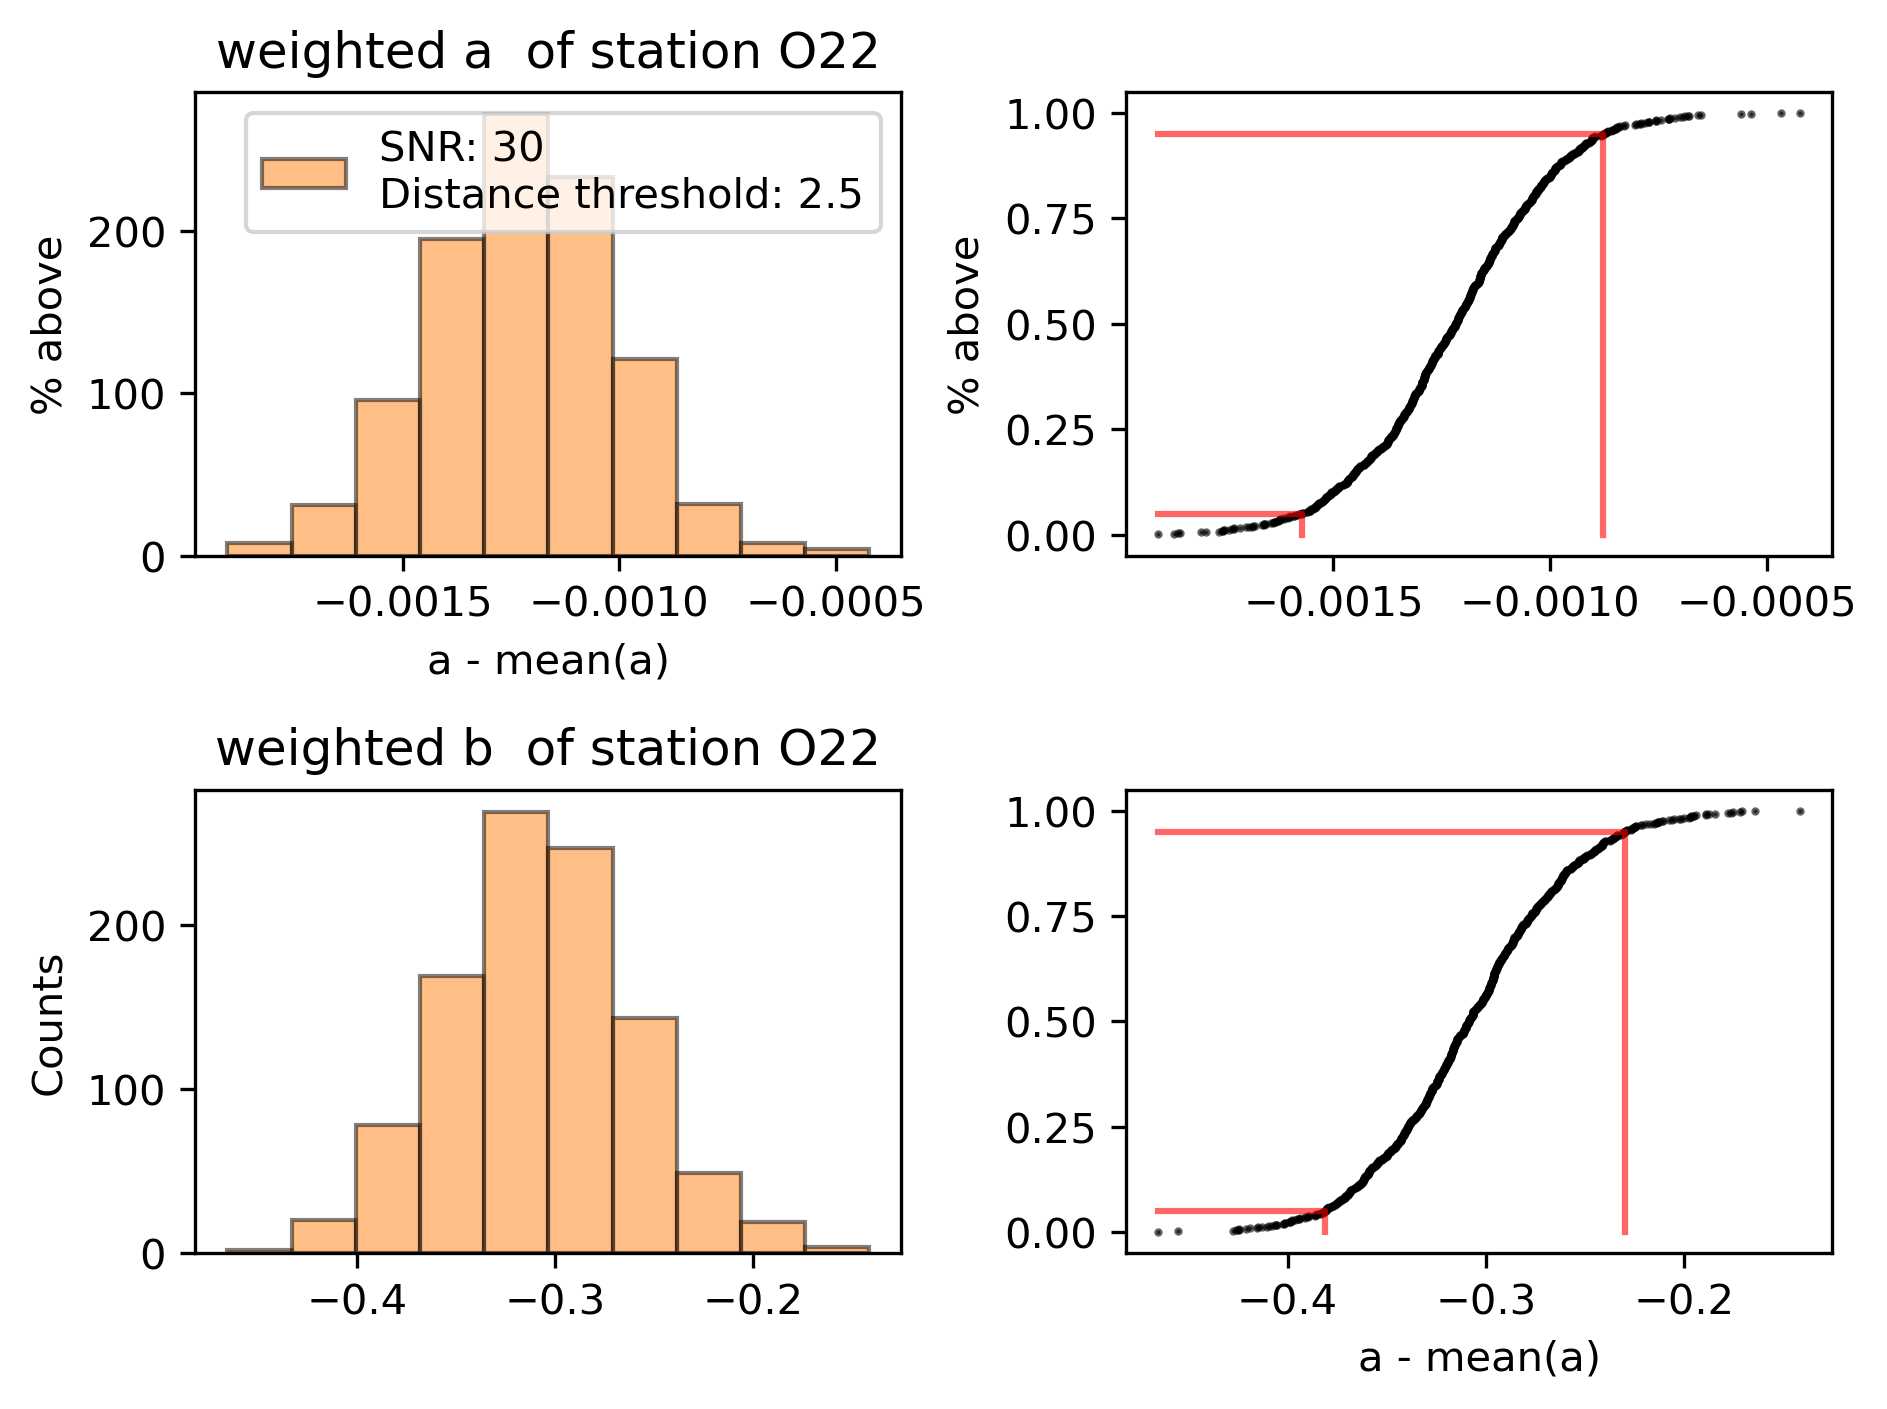

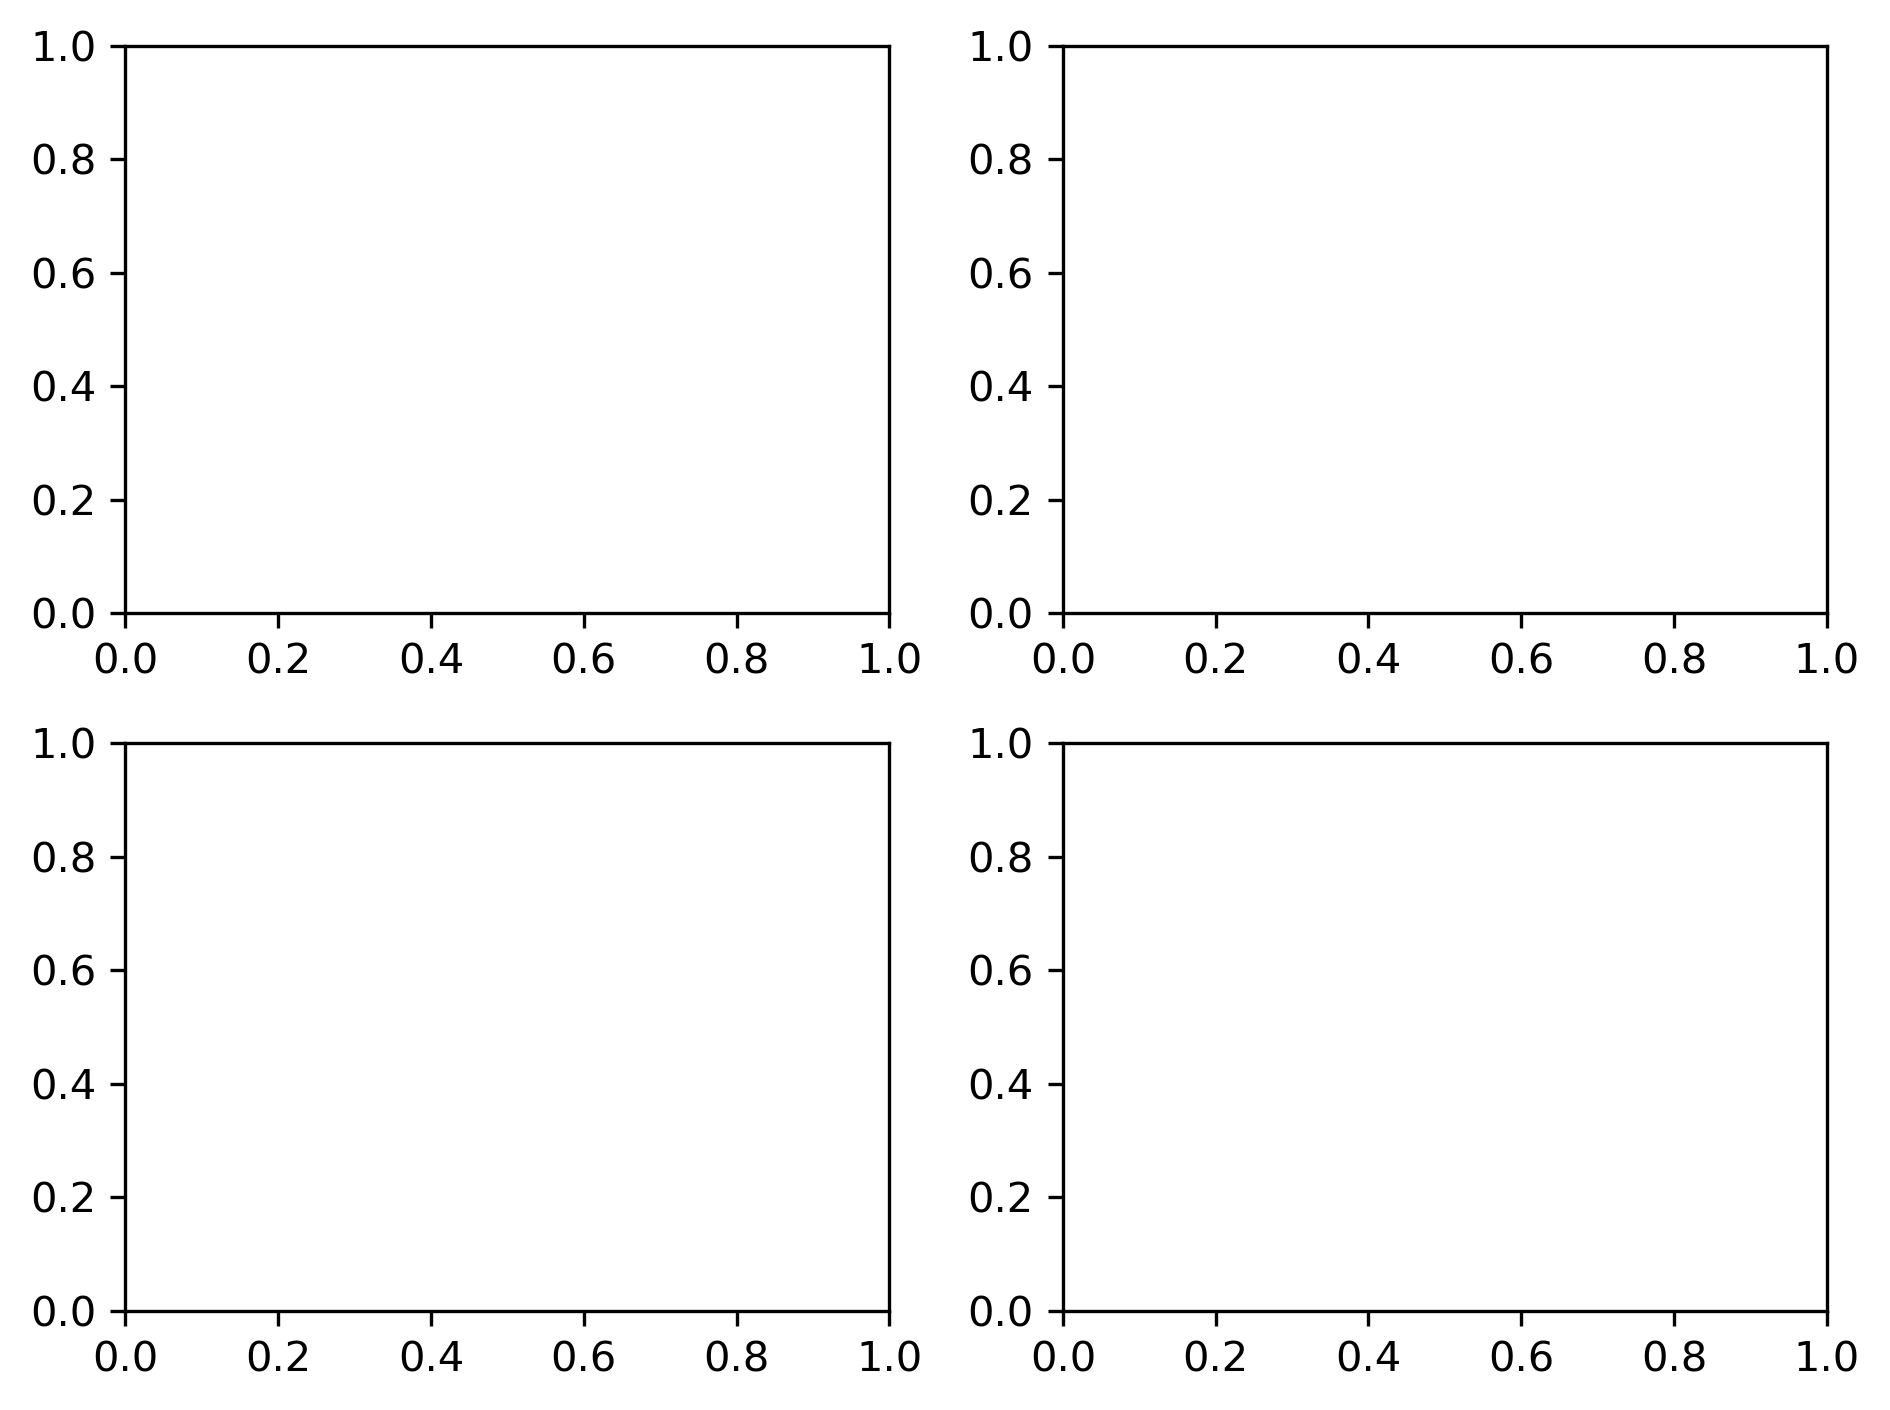

In [9]:
binwidth = 0.0001
iteration = "snr_trh_" + str(snr_trh) + "__dist_trh_" + str(dist_trh)
for station in cd.stations:
    if not station.needs_correction:
        continue
    #if station.code not in ["O01", "O10", "O19", "O20"]:
    #    continue
    sta = station.code
    fig, ax  = plt.subplots(2, 2, dpi=300) #, sharey='col')
    min_limit_conf_interval = 1000
    for i, inverse_method in enumerate([
        #"lstsq a ",
        "weighted a ",
        "weighted b ",
        #"lstsq b "
    ]):

        title = inverse_method + sta + iteration
        values = results[title]
        if len(values) == 0:
            continue
        # mean_values = mean(values)
        # values = [val - mean_values for val in values]
        ax[i, 0].hist(values, 
                      # density=True,
                   #bins=np.arange(min(values), max(values) + binwidth,
                   #               binwidth),
                   alpha=0.5,
                   facecolor="C1",
                   edgecolor="black",
                   linewidth=1,
                   label=("SNR: " + str(snr_trh) +
                           "\nDistance threshold: " + str(dist_trh))
                   )
        
        
        x = np.sort(values)
        n = x.size
        y = np.arange(1, n+1) / n

        ax[i, 1].scatter(x, y,
                         s=1,
                         alpha=0.6,
                         c="k"
                         )
        print(title)
        for conf_interval in [0.05, 0.95]:
            x_interval = x[np.argmin(np.abs(np.array(y)-conf_interval))]
            x_0 = x[0]
            if x_0 < min_limit_conf_interval:
                min_limit_conf_interval = x_0
            ax[i, 1].plot([x_0, x_interval, x_interval], [conf_interval, conf_interval, 0],# facecolors="none",
                             c="r",
                             zorder=99,
                             alpha=0.6,
                             )
            if inverse_method == "weighted a ":
                if conf_interval == 0.05:
                    station._05CI_a = x_interval
                elif conf_interval == 0.95:
                    station._95CI_a = x_interval
            if inverse_method == "weighted b ":
                if conf_interval == 0.05:
                    station._05CI_b = x_interval
                elif conf_interval == 0.95:
                    station._95CI_b = x_interval
            
            print(station.code, " confidence interval ", str(conf_interval),
                  ": ", str(x_interval))
        ax[i, 0].set_title(inverse_method + " of station " + sta)
        ax[i, i].set_xlabel("a - mean(a)")
        ax[i, 0].set_ylabel("Counts")
        ax[0, i].set_ylabel("% above")
        ax[0, 0].legend()
        # ax[i, 1].set_xlim(left=min_limit_conf_interval)
        
    fig.tight_layout()
    plt.show()

In [11]:
cd.stations[0]._95CI_b

-0.27490517920544777

In [40]:
import obspy
skew_values_file = "skew_values.csv"
path2file_skew = os.path.join(module_path, skew_values_file)
skew_df = pd.read_csv(path2file_skew, delimiter=",", header=0)

sensor_codes = skew_df["Sensor code"]
starttimes = skew_df["Start time"]
endtimes = skew_df["End time"]
ref_time = cd.reference_time
skew_measurements = skew_df["skew seconds"]


initial_shift = []
final_shift = []
corrected_stations = []
included_skews = []
clock_drift_per_day = []
CI_a = []
for station, starttime, endtime, skew in zip(sensor_codes, starttimes,
                                       endtimes, skew_measurements):
    if station in cd.station_names:
        sta_obj = cd.get_station(station)
        a = float(cd.solution["a ("+ station + ")"])
        b = float(cd.solution["b ("+ station + ")"])
        dt_start = (obspy.UTCDateTime(starttime) - ref_time)/86400
        dt_ins_start = a*(dt_start) + b
        initial_shift.append(dt_ins_start)
        
        try:
            dt_end = (obspy.UTCDateTime(endtime) - ref_time)/86400
            dt_ins_end = a*(dt_end) + b
            
        except:
            dt_ins_end = "Recovered with dead battery"
        final_shift.append(dt_ins_end)
        corrected_stations.append(station)
        included_skews.append(skew)
        clock_drift_per_day.append(a * 365)
        
        if hasattr(sta_obj, '_95CI_a'):
            CI_a.append("[" + str(sta_obj._95CI_a * 365)[:8]
                        + ", " + str(sta_obj._05CI_a * 365)[:8]
                        + "]"
                       )
            if a < sta_obj._05CI_a or a > sta_obj._95CI_a:
                raise
        
final_results = pd.DataFrame(list(zip(corrected_stations, clock_drift_per_day,
                                      CI_a,
                                      initial_shift, final_shift, included_skews)),
                     columns = ["Sensor code", "Clock drift [s/year]",
                                "[a] 95 % CI",
                                "Incurred timing error at t=0 [s]",
                               "Timing error at the time of recovery [s]",
                                "Observed Skew [s]", 
                                ])
display(final_results)
print(final_results.to_latex(index=False))

,Sensor code,Clock drift [s/year],95 % CI,Incurred timing error at t=0 [s],Timing error at the time of recovery [s],Observed Skew [s]
0,O01,-0.734739,"[-0.66530, -0.81128]",-0.312892,-1.055899,2.023125
1,O02,-1.055136,"[-0.89881, -1.21819]",-0.115932,-1.073991,1.790906
2,O03,-0.401807,"[-0.14431, -0.90894]",-0.109016,-0.51527,1.137506
3,O04,-0.770560,"[-0.54996, -1.04575]",-0.189581,-0.968726,1.774437
4,O06,-0.172589,"[0.075594, -0.42642]",-0.167178,-0.343849,1.129468
5,O08,-0.104288,"[0.409765, -0.50414]",-0.324112,-0.433947,1.099625
6,O10,-1.095582,"[-1.02173, -1.25883]",-0.225838,-1.354066,1.813093
7,O11,-0.667440,"[-0.42681, -1.02029]",-0.404515,-1.089599,1.469656
8,O14,-0.304885,"[-0.16021, -0.60914]",-0.211672,-0.524822,1.268156
9,O15,-1.465134,"[-0.82919, -1.97553]",-0.342056,-1.839114,2.669093


\begin{tabular}{lrlrlr}
\toprule
Sensor code &  Clock drift [s/year] &              95 \% CI &  Incurred timing error at t=0 [s] & Timing error at the time of recovery [s] &  Observed Skew [s] \\
\midrule
        O01 &             -0.734739 & [-0.66530, -0.81128] &                         -0.312892 &                                -1.055899 &           2.023125 \\
        O02 &             -1.055136 & [-0.89881, -1.21819] &                         -0.115932 &                                -1.073991 &           1.790906 \\
        O03 &             -0.401807 & [-0.14431, -0.90894] &                         -0.109016 &                                 -0.51527 &           1.137506 \\
        O04 &             -0.770560 & [-0.54996, -1.04575] &                         -0.189581 &                                -0.968726 &           1.774437 \\
        O06 &             -0.172589 & [0.075594, -0.42642] &                         -0.167178 &                                -0.343849 &        

In [18]:
cd.solution

,a (O01),b (O01),a (O02),b (O02),a (O03),b (O03),a (O04),b (O04),a (O06),b (O06),...,a (O19),b (O19),a (O20),b (O20),a (O21),b (O21),a (O22),b (O22),a (O23),b (O23)
values,-0.002013,-0.309267,-0.002891,-0.110746,-0.001101,-0.10698,-0.002111,-0.18572,-0.000473,-0.166786,...,-0.0027,-0.376566,-0.012745,0.03515,-0.003382,-0.186624,-0.001137,-0.316193,-0.000857,-0.299499


lstsq a O10snr_trh_30__dist_trh_2.5
O10  confidence interval  0.05 :  -0.000286713676679
O10  confidence interval  0.95 :  0.000291123738623
weighted a O10snr_trh_30__dist_trh_2.5
O10  confidence interval  0.05 :  -0.000332028024332
O10  confidence interval  0.95 :  0.000317575142571


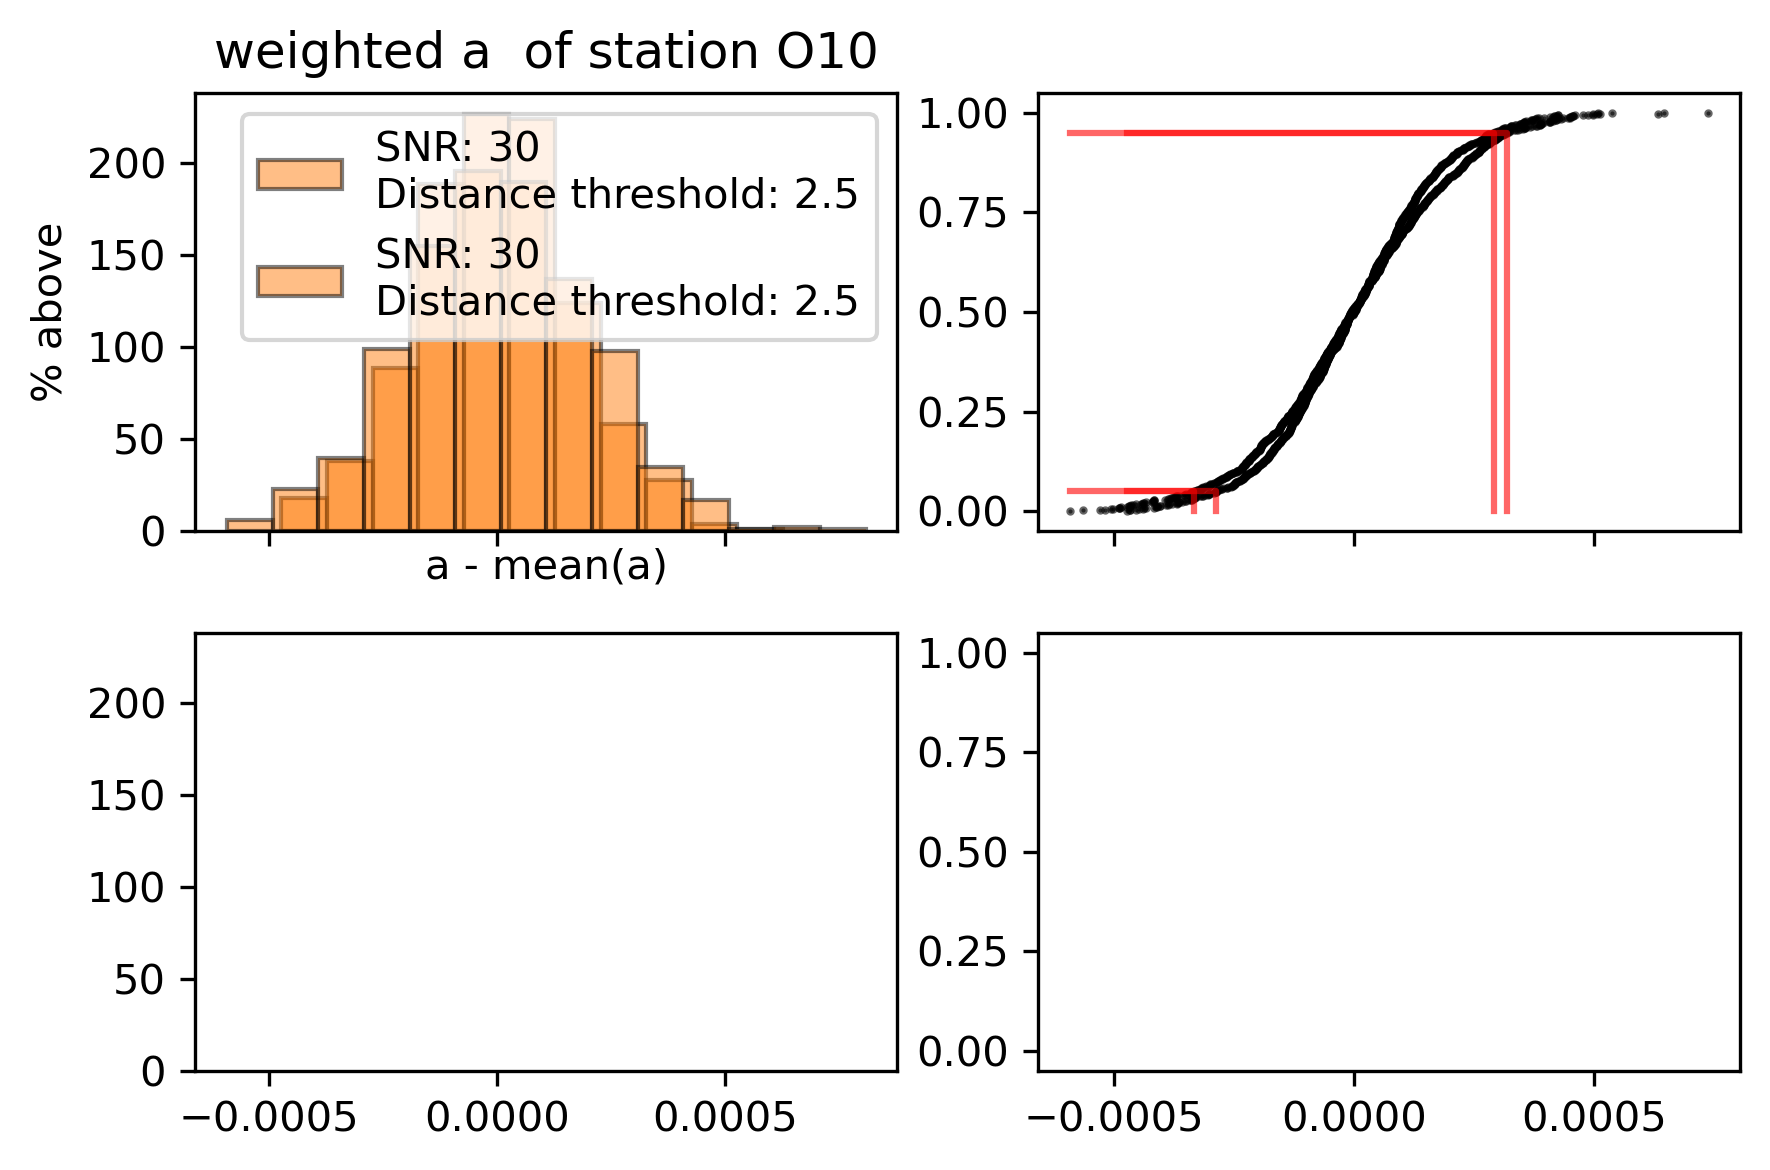

KeyboardInterrupt: 

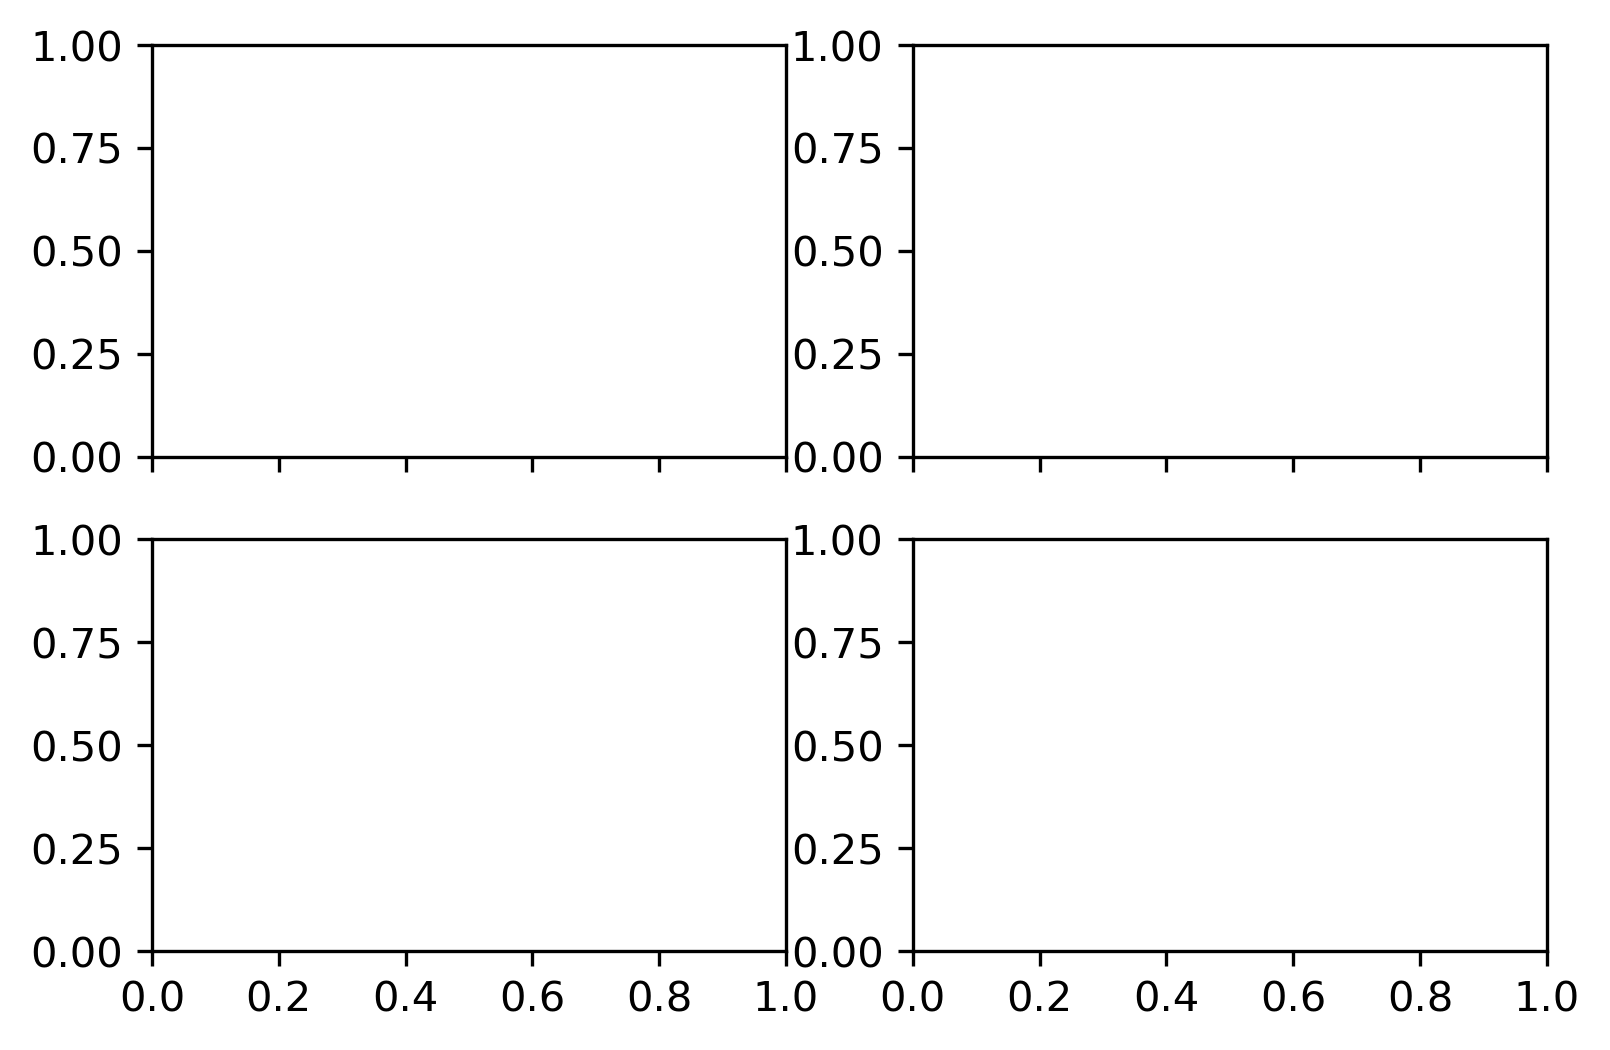

In [8]:
output_dir = "/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/bootstrap/"
with open(output_dir + "refinedInversion_bootstrap.pkl", 'rb') as f:
    results = pickle.load(f)
binwidth = 0.0001
iteration = "snr_trh_" + str(snr_trh) + "__dist_trh_" + str(dist_trh)
for station in cd.stations:
    if not station.needs_correction:
        continue
    if station.code not in ["O15", "O10", "O19", "O20"]:
        continue
    sta = station.code
    fig, ax  = plt.subplots(2, 2, dpi=300, sharex='col', sharey='col')
    min_limit_conf_interval = 1000
    for i, inverse_method in enumerate([
        "lstsq a ",
        #"weighted b ",
        "weighted a ",
        #"lstsq b "
    ]):
        i=0
        title = inverse_method + sta + iteration
        values = results[title]
        if len(values) == 0:
            continue
        mean_values = mean(values)
        values = [val - mean_values for val in values]
        ax[i, 0].hist(values, 
                      # density=True,
                   bins=np.arange(min(values), max(values) + binwidth,
                                  binwidth),
                   alpha=0.5,
                   facecolor="C1",
                   edgecolor="black",
                   linewidth=1,
                   label=("SNR: " + str(snr_trh) +
                           "\nDistance threshold: " + str(dist_trh))
                   )
        x = np.sort(values)
        n = x.size
        y = np.arange(1, n+1) / n

        ax[i, 1].scatter(x, y,
                         s=1,
                         alpha=0.6,
                         c="k"
                         )
        print(title)
        for conf_interval in [0.05, 0.95]:
            x_interval = x[np.argmin(np.abs(np.array(y)-conf_interval))]
            x_0 = x[0]
            if x_0 < min_limit_conf_interval:
                min_limit_conf_interval = x_0
            ax[i, 1].plot([x_0, x_interval, x_interval], [conf_interval, conf_interval, 0],# facecolors="none",
                             c="r",
                             zorder=99,
                             alpha=0.6,
                             )
            
            print(station.code, " confidence interval ", str(conf_interval),
                  ": ", str(x_interval))
        ax[i, 0].set_title(inverse_method + " of station " + sta)
        ax[i, i].set_xlabel("a - mean(a)")
        ax[i, 0].set_ylabel("Counts")
        ax[0, i].set_ylabel("% above")
        ax[0, 0].legend()
        # ax[i, 1].set_xlim(left=min_limit_conf_interval)
        
    fig.tight_layout()
    plt.show()